In [1]:
#Fix Variance and utility arrays for different strategies
import numpy as np
import scipy
import math
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import random
from scipy.stats import norm
from scipy.stats import lognorm
from scipy.stats import weibull_min
from scipy.signal import spectrogram
from scipy.linalg import eigh, cholesky
from numpy import log as ln
import networkx as nx
import pandas as pd
import bisect
import seaborn as sns
import sympy as sp
from sympy import symbols, Eq, solve
import json
from time import process_time
import sys
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle
import seaborn as sns
import pandas as pd
import ptitprince
import os
import matplotlib.tri as tri

# Overall Model Parameters

# Model Functions

In [145]:
#Insert SLURM code here                                                                                                                                                                                     
#args = sys.argv[:]
#input_a = args[1] #Risk Factor                                                                                                                                                                              
#input_b = args[2] #Correlation                                                                                                                                                                             
#input_c = args[3] #Altruism Factor
#input_d = args[4] #k-factor

#Fixed parameters
sensitivity_steps = 1 #Number of parameter values scanned for sensitivity parameter specified below
simulations = 1
annual_decisions = 4 #Number of times an agent is evaluating strategy on average
households = 500
time = 200 * households
mu_farm = 260.9 #For cereal crops only 176.5 #For all crops 260.93 #Previously mu_farm = 163.4
farm_k = 0.798 #For cereal crops only 1.31 #For all crops 0.798 #For STD = 321; previously k = 0.808 #Shape factor for farming income distribution (Weibull)
max_farm = 2500 #For cereal crops only: 732.1 #For combined: 2500 #99th percentile of farm income/cycle (in USD) to truncate Weibull - based on CVFS total revenues
eta = 0.9 #Proportion of full farm income that is still earned by households engaging in migration
cost_farm = 221.3 #170


migration_type = 'Combined'

if migration_type == 'Combined':
    mu_migrate =   600.8 #Without 0's 1016 #CVFS average with 0s included 872.2 #664.9 from CVFS Data #600.8 from Shrestha data - combined #For intl only 872.2 
    var_migrate = 648.8 ** 2 #Without 0's 1083 ** 2 #From CVFS data with 0's 825.8 ** 2 #For intl only: 825.8 ** 2 #For combined: 648.8 ** 2 #Oriignal 998.2 ** 2
    cost_migrate = 700.6 #Weighted Avg from Shrestha 700.6 #For intl only:1133 #500
    
elif migration_type == 'Local':
    mu_migrate = 200 
    var_migrate = 190 ** 2 
    cost_migrate = 62.5

elif migration_type == 'International':
    mu_migrate = 872.2
    var_migrate = 825.8 ** 2
    cost_migrate = 1133

else: 
    raise ValueError ('Migration type improperly specified')
    

subs_fraction = 0.0 #Proportional subsidy on cost of insurance premium
matching = 0 #Amount of matching dollars government contributes to revenue-sharing pools, per hh per cycle

beta = 0.2 #Proportion of income that is shared in collective
objective_drought = 0.3 #Presumed drought risk in 2021, to set income threshold for drought vs. non-drought year
p_drought = 0.6 #This can vary based on severity of climate risk that is to be modelled
p_cov = 0.5 #Pearson's correlation coefficient for farming (i.e. covariate risk)
rho_mig = 0.0 #Pearson's correlation coefficient for farming and migration income streams
init_insure = 0.00 #Initial adopters of insurance

discount_rate = 0.1
time_horizon = 10 #Number of cycles across which a household evaluates options

utility_function = 'Self-Interested'
risk_factor = 0.5
losav = 1.33 #Scaled Loss aversion factor for MVT

pref_fraction = 1.0 #Fraction of households espousing social preferences specified below
altruism_factor = 0.0 #Degree to which individuals account for other households' utility, should range from [0,1]
max_altruism = 1 #Scalar by which others' utilities are multiplied, before applying altruism factor. Can take on any non-zero number. 1 = household caring about the sum of other households equally to their own for altruism factor = 1. 
k = 0.0 #Probability of an agent following another agent

sel_strength = 27.73 #Strength of selection effect; 27.73 gives 80% change of switching for relative utility gap of 5%
mutation_rate= 1 /households #1 / households

consump_thres = 84.43 #Estimated threshold taken from CVFS for amount of income needed to ensure food needs are met
 


## Calculating Variances of Drought and Non-Drought Income Distributions

In [3]:
#Calculate variance of truncated distributions (for drought vs. non-drought distributions)
def trunc_var(income_sample, mu):
    running_var = 0
    N = len(income_sample)
    for i in range(N):
        running_var += (income_sample[i] - mu) ** 2
    
    var = running_var / (N - 1)
    
    return var

#Define drought and non-drought portions of farming income distribution
def farm_drought_0(adj_k, adj_scale, p_drought, max_farm):
    
    new_dist = adj_scale * np.random.weibull(adj_k, size=100000)
    adj_income = list(np.sort(new_dist))
    
    adj_drought_index = int(p_drought * len(adj_income))
    adj_nondrought_incomes = np.array(adj_income[adj_drought_index:len(adj_income)]).astype(float)
    
    if p_drought == 0:
        adj_drought_incomes = adj_nondrought_incomes
    else:
        adj_drought_incomes = np.array(adj_income[0:adj_drought_index]).astype(float)
    
    mu_farm_drought = np.average(adj_drought_incomes)
    mu_farm_nd = np.average(adj_nondrought_incomes)
    mu_farm = np.average(np.array(adj_income).astype(float))
    
    var_drought = trunc_var(adj_drought_incomes, mu_farm)
    var_nd = trunc_var(adj_nondrought_incomes, mu_farm)
    
    uninsured_var = trunc_var(adj_income, mu_farm)
    
    #Adjusting income distribution during drought years for insurance holders
    payout_distribution = adj_drought_incomes + (mu_farm_nd - mu_farm_drought)
    payout_var = trunc_var(payout_distribution, mu_farm_nd) 
    insured_var = p_drought * payout_var + (1 - p_drought) * var_nd
    
    return mu_farm_drought, mu_farm_nd, uninsured_var, insured_var

#Function to generate correlated random income samples, given value of p_cov
def corr_income(samples, p_cov, adj_scale, adj_k):
    
    sims = len(samples)
    hh = len(samples[0])
    
    #Set desired covariance matrix based on p_cov
    cov_matrix = np.ones((hh, hh)) * p_cov
    
    np.fill_diagonal(cov_matrix, 1)
    #De-compose covariance matrix into matrix c such that CC^T = matrix
    c = cholesky(cov_matrix, lower=True)    
    
    y = np.zeros((hh, sims))
    xm = np.asmatrix(samples)
    x = xm.transpose()

    #Generating samples based on specified households and cycles
    y = np.dot(c, x)
        
    return y

#Function to generate correlated random income samples for drought and non-drought regmies, given value of p_cov
def corr_income2(samples, p_cov, p_index, p_drought):
    simulations = len(samples)
    hh = len(samples[0])
    
    #Set desired covariance matrix based on p_cov
    cov_matrix = np.ones((hh, hh)) * p_cov
    
    np.fill_diagonal(cov_matrix, 1)
    #De-compose covariance matrix into matrix c such that CC^T = matrix
    c = cholesky(cov_matrix, lower=True)        
    
    drought = []
    nondrought = []
    
    for a in range(simulations):
        if p_index[a] < p_drought:
            drought.append(samples[a,:])
        else:
            nondrought.append(samples[a,:])
    
    regimes = [drought, nondrought]
    
    regime_incomes = []
    
    #Generate hh x sims size matrix of correlated incomes
    for r in regimes:
        sims = len(r)
        if sims > 0:
            y = np.zeros((hh, sims))
            xm = np.asmatrix(r)
       
            x = xm.transpose()

            #Generating samples based on specified households and cycles
            y = np.dot(c, x)
            regime_incomes.append(y)
    
   
    #Re-splicing drought and non-drought regimes into one overall matrix
    income_matrix = []
    d = 0 #drought counter
    n = 0 #non-drought counter
    for a in range(simulations):
       
        
        if p_index[a] < p_drought:
            income_matrix.append(regime_incomes[0][:,d])
            d += 1
        else:
            income_matrix.append(regime_incomes[-1][:,n])
            n += 1
            
    correlated_matrix = np.array(income_matrix)
    
    
    return correlated_matrix

#Split Weibull distribution into drought and non-drought portions (for income draws)
def weib_split(adj_k, adj_scale, p_drought, max_farm):
    
    samples = 100000
    new_dist = adj_scale * np.random.weibull(adj_k, size=samples)
    adj_income = list(np.sort(new_dist))
    
    adj_drought_index = int(p_drought * len(adj_income))
    adj_nondrought_incomes = np.array(adj_income[adj_drought_index:len(adj_income)]).astype(float)
    
    if p_drought == 0:
        adj_drought_incomes = adj_nondrought_incomes
    else:
        adj_drought_incomes = np.array(adj_income[0:adj_drought_index]).astype(float)

    return adj_nondrought_incomes, adj_drought_incomes

#Draw from either drought or non-drought portion of Weibull distribution
def weib_draw(drought_incomes, nondrought_incomes, p, p_drought):
    
    if p < p_drought:
        i = np.random.randint(0,len(drought_incomes))
        sample = drought_incomes[i]
    else:
        i = np.random.randint(0, len(nondrought_incomes))
        sample = nondrought_incomes[i]
    
    return sample


#Adjust Weibull distribution parameters based on drought risk
def wei_adjust(mu_farm, farm_k, p_drought, objective_drought, max_farm):
    
    scale = (mu_farm / math.gamma(1 + 1 / farm_k))
    income_distribution = scale * np.random.weibull(farm_k, size=1000000)
    sorted_income = list(np.sort(income_distribution))
    drought_index = int(objective_drought * len(sorted_income)) - 1
    drought_threshold = sorted_income[drought_index]
    print(drought_threshold)
        
    #Identify value of Weibull cdf that represents 99.99 percentile
    last_percent = max_farm
    print(last_percent)
    
    x, y = symbols('x y')
    eq1 = Eq(1 - sp.exp(-(last_percent/ y) ** x), 0.9999)
    eq2 = Eq(1 - sp.exp(-(drought_threshold / y) ** x), p_drought)
    
    adj_k, adj_scale = solve((eq1, eq2), (x,y))[-1]
    
    return adj_k, adj_scale


#Calculate variance from Weibull distribution parameters
def wei_var(mu, k):
    scale = (mu / math.gamma(1 + 1 / k))
    variance = scale ** 2 * (math.gamma(1 + 2 / k) - (math.gamma(1 + 1 / k)) ** 2)
    return variance

def wei_scale(mean, shape):
    scale = (mean / math.gamma(1 + 1 / shape))
    
    return scale

#Function that returns Weibull shape parameter (k) from mean and std dev
def wei_shape(mean, std_dev):
    k = (std_dev / mean) ** -1.086
    
    return k

def lognorm_factors(mean, std_dev):
    mu = np.log(mean / math.sqrt(1 + std_dev ** 2 / mean ** 2))
    sigma = math.sqrt(np.log(1 + std_dev ** 2 / mean ** 2))
    
    return mu, sigma

#Function to calculate NPV of an array
def npv_calc(array, time_horizon, discount_rate):
    npv = 0
    
    for i in range(time_horizon):
        npv += array[i] / ((1 + discount_rate) ** i)
        
    return npv


def gini_calc(households, household_income):
    gini_sum = 0 
    community_total = 0
    
    #Setting household(i) income to 0 if it is negative
    for i in range(households):
        if household_income[i] < 0:
            agent_i_income = 0
        else:
            agent_i_income = household_income[i]
        
        #Adding difference in i and j income to running Gini total (if it hasn't already been compared)
        for j in range(households): 
            if j > i:
                if household_income[j] < 0:
                    agent_j_income = 0
                else:
                    agent_j_income = household_income[j]
                
                gini_sum += abs(agent_i_income - agent_j_income)
            
            else:
                gini_sum += 0
        
        community_total += agent_i_income

    community_avg_income = community_total / households
    
    if community_avg_income == 0:
        gini = gini_sum / (2 * 0.01 * households ** 2)
    else:
        gini = gini_sum / (2 * community_avg_income * households ** 2) 

    return gini


## Calculating Incomes and NPV of Income

In [4]:
#Return utility of a gain or loss relative to reference point
def loss_eval(payoff, reference, losav, risk_factor, std):
    
    if payoff < reference:
        util = losav * ((payoff - reference) - risk_factor * std)
    else:
        util = payoff - reference - risk_factor * std
    
    return util


#Calculate NPV based on annual income, costs, and discount rate
def utility_horizon(time_horizon, cost_farm, consum_thres, strategy, losav, cost_migrate, remittances, risk_factor, var_migrate, p_drought, drought_payoff, std, nondrought_payoff):
    farm_utility = np.zeros(time_horizon)
    migrate_utility = np.zeros(time_horizon)
    total_utility = np.zeros(time_horizon)
    reference = 0 #0 Because cost_farm is already accounted for in payoffs
    
    for i in range(0, time_horizon):
        if 'Migrate' in strategy and i == 0:
            migrate_utility[i] = -losav * cost_migrate
        elif 'Migrate' in strategy:
            migrate_utility[i] = remittances - risk_factor * math.sqrt(var_migrate)
        
        farm_utility[i] = p_drought * loss_eval(drought_payoff, reference, losav, risk_factor, std[i]) + (1 - p_drought) * loss_eval(nondrought_payoff, reference, losav, risk_factor, std[i])

        total_utility[i] = farm_utility[i] + migrate_utility[i]
        
    return total_utility


#Shared Income calc
def shared_income(strategy_names, beta, frequency_dist, farm_income, matching):
    shared_pool = 0
    shared_dist = 0
    for item in strategy_names:
        #Check whehter we should adjust how much migrant households contribute/receive in shared income
        if 'Share' in item:
            shared_pool += beta * frequency_dist[item] * farm_income[item]
            shared_dist += frequency_dist[item]
    
    if shared_dist == 0:
        household_share = 0
    else:
        household_share = (shared_pool + shared_dist * matching) / shared_dist
        
    shared_income_received = {'Farm': 0, 
                   'FarmMigrate': 0, 
                   'Farm+Share': household_share, 
                   'FarmMigrate+Share': household_share, 
                   'Farm+Ins': 0, 
                   'FarmMigrate+Ins': 0, 
                   'Farm+Share+Ins': household_share, 
                   'FarmMigrate+Share+Ins': household_share}
    
    return shared_income_received

#Calculate gains and losses of strategy options for droughts and non-droughts
def payoffs_calc(strategy_names, p_drought, mu_farm_nd, mu_farm_drought, eta, mu_migrate, beta, frequency_dist, matching, cost_farm, subsidy, time_horizon, losav, cost_migrate):
    drought_payoff = {key : 0 for key in strategy_names} 
    nondrought_payoff = {key : 0 for key in strategy_names} 
    premium = p_drought * (mu_farm_nd - mu_farm_drought)

    #Income generated by own household
    drought_income = {'Farm': mu_farm_drought, 
                     'FarmMigrate': eta * mu_farm_drought, 
                     'Farm+Share': mu_farm_drought, 
                     'FarmMigrate+Share': eta * mu_farm_drought, 
                     'Farm+Ins': mu_farm_nd, 
                     'FarmMigrate+Ins': eta * mu_farm_nd, 
                     'Farm+Share+Ins':  mu_farm_nd, 
                     'FarmMigrate+Share+Ins': eta * mu_farm_nd}
    
    nondrought_income = {'Farm': mu_farm_nd, 
                     'FarmMigrate': eta * mu_farm_nd, 
                     'Farm+Share': mu_farm_nd, 
                     'FarmMigrate+Share': eta * mu_farm_nd, 
                     'Farm+Ins': mu_farm_nd, 
                     'FarmMigrate+Ins': eta * mu_farm_nd, 
                     'Farm+Share+Ins': mu_farm_nd, 
                     'FarmMigrate+Share+Ins': eta * mu_farm_nd}
    
    remittances = {'Farm': 0, 
                   'FarmMigrate': mu_migrate, 
                   'Farm+Share': 0, 
                   'FarmMigrate+Share': mu_migrate, 
                   'Farm+Ins': 0, 
                   'FarmMigrate+Ins': mu_migrate, 
                   'Farm+Share+Ins': 0, 
                   'FarmMigrate+Share+Ins': mu_migrate}
    
    shared_drought = shared_income(strategy_names, beta, frequency_dist, drought_income, matching)
    shared_nd = shared_income(strategy_names, beta, frequency_dist, nondrought_income, matching)
    
    
    cost_drought = {'Farm': cost_farm, 
            'FarmMigrate': cost_farm, 
            'Farm+Share': cost_farm + beta * drought_income['Farm+Share'], 
            'FarmMigrate+Share': cost_farm + beta * drought_income['FarmMigrate+Share'], 
            'Farm+Ins': cost_farm + premium - subsidy, 
            'FarmMigrate+Ins': cost_farm + eta * premium - subsidy, 
            'Farm+Share+Ins': cost_farm + premium + beta * drought_income['Farm+Share+Ins'] - subsidy, 
            'FarmMigrate+Share+Ins': cost_farm + eta * premium + beta * drought_income['FarmMigrate+Share+Ins'] - subsidy}
    
    cost_nondrought = {'Farm': cost_farm, 
            'FarmMigrate': cost_farm, 
            'Farm+Share': cost_farm + beta * nondrought_income['Farm+Share'], 
            'FarmMigrate+Share': cost_farm + beta * nondrought_income['FarmMigrate+Share'], 
            'Farm+Ins': cost_farm + premium - subsidy, 
            'FarmMigrate+Ins': cost_farm + eta * premium - subsidy, 
            'Farm+Share+Ins': cost_farm + premium + beta * nondrought_income['Farm+Share+Ins'] - subsidy, 
            'FarmMigrate+Share+Ins': cost_farm + eta * premium + beta * nondrought_income['FarmMigrate+Share+Ins'] - subsidy}
    
    for item in strategy_names:
        drought_payoff[item] = drought_income[item] + shared_drought[item] - cost_drought[item]
        nondrought_payoff[item] = nondrought_income[item] + shared_nd[item] - cost_nondrought[item]        

    return drought_payoff, nondrought_payoff


        

## Calcluating Variances and NPV of Variance

In [5]:
#NOTE - ensure combined variance accounts for covariance between all players of the same strategy

#Variance calculation - calls upon combined_variance and npv_variance functions
def variance_calc(mu_farm, farm_k, p_drought, eta, uninsured_var, insured_var, var_migrate, beta, rho_mig, frequency_dist, households, p_cov, strategy_names, time_horizon, discount_rate):
    std_array = {key : 0 for key in strategy_names}
    
    var_farm = wei_var(mu_farm, farm_k)
    
    #Farming income variance, before accounting for shared pool
    base_farm_variance = {'Farm': uninsured_var, 
                   'FarmMigrate': (eta ** 2) * uninsured_var, 
                   'Farm+Share': uninsured_var, 
                   'FarmMigrate+Share': (eta ** 2) * uninsured_var, 
                   'Farm+Ins': insured_var, 
                   'FarmMigrate+Ins': (eta ** 2) * insured_var, 
                   'Farm+Share+Ins': insured_var, 
                   'FarmMigrate+Share+Ins': (eta ** 2) * insured_var} 
    
    
    #Remittance income variance before accounting for shared pool
    base_remittance_variance = {'Farm': 0, 
                   'FarmMigrate': var_migrate, 
                   'Farm+Share': 0, 
                   'FarmMigrate+Share': var_migrate, 
                   'Farm+Ins': 0, 
                   'FarmMigrate+Ins': var_migrate, 
                   'Farm+Share+Ins': 0, 
                   'FarmMigrate+Share+Ins': var_migrate}
    
    #Calculating variance of shared strategies
    pool_dist = 0
    for item in strategy_names:
        if 'Share' in item:
            pool_dist += frequency_dist[item]
    
    total_farm_variance = {key: 0 for key in strategy_names}
    total_variance = {key : 0 for key in strategy_names}
    total_std = {key : 0 for key in strategy_names}
    
    for item in strategy_names:
        if 'Share' in item and frequency_dist[item] != 0:
            total_farm_variance[item] = combined_variance(beta, pool_dist, households, p_cov, base_farm_variance, item, frequency_dist, strategy_names)
            
        else:
            total_farm_variance[item] = base_farm_variance[item]   
        
        #Adding farm and remittance variances
        total_variance[item] = total_farm_variance[item] + base_remittance_variance[item]
        total_std[item] = math.sqrt(total_variance[item])
        
        #Calculates NPV of Standard Deviation
        std_array[item] = std_horizon(time_horizon, item, total_std, discount_rate, var_migrate)
    
    return std_array

#Function that calculates combined variance for sharing pool between income streams A and B, given correlation coefficient p_cov
def combined_variance(beta, pool_dist, households, p_cov, individual_variance, strategy_a, frequency_dist, strategy_names):
    
    pool_hh = pool_dist * households
    #Factors for kept, shared, and received variances
    kept = (1 - beta) #Factor for portion of a household's income that is kept (i.e. not shared with pool)
    shared = beta / pool_hh #Factor for portion of a household's income that is initially shared to pool and returned to household 
    
    #Variance and Covariance of kept and shared portions from household's own income
    own_covariance = (kept ** 2 + shared ** 2  + (2 * kept * shared)) * individual_variance[strategy_a]
    
    #Creating Covariance matrix
    shared_strategies = []
    for name in strategy_names:
        if 'Share' in name:
            shared_strategies.append(name)
    
    covariance_matrix = {key : {} for key in shared_strategies}
    
    for row in shared_strategies:
        covariance_matrix[row] = {column: p_cov for column in shared_strategies}
        
    #Covariance between a household's kept farm income (strategy_a) and farm income received from rest of the pool (item)
    contributed_cov = 0
    for item in shared_strategies:
        if item == strategy_a and frequency_dist[strategy_a] > 0:
            contributed_cov += 2 * covariance_matrix[strategy_a][item] * kept * beta * (frequency_dist[item] * households - 1) / pool_hh * math.sqrt(individual_variance[strategy_a]) * math.sqrt(individual_variance[item])

        else:
            contributed_cov += 2 * covariance_matrix[strategy_a][item] * kept * beta * frequency_dist[item] * households / pool_hh * math.sqrt(individual_variance[strategy_a]) * math.sqrt(individual_variance[item])
        
    
    #Variance and Covariance between income from other contributors within a pool that is received by a household
    pool_var = 0
    pool_cov = 0
    for i, row in enumerate(shared_strategies):
        X_i = frequency_dist[row] * households #Number of households playing strategy "row", a.k.a strategy "i"
        
        #Covariance of contributed amounts for same strategy
        if row == strategy_a and frequency_dist[strategy_a] > 0:
            pool_var += ((X_i - 1) * beta ** 2 / (pool_hh) ** 2 * individual_variance[row] + 2 * X_i * (X_i - 1) * covariance_matrix[row][row] * beta ** 2 / (2 * (pool_hh) ** 2) * individual_variance[row])
       
        elif frequency_dist[row] > 0:
            pool_var += ((X_i * beta ** 2 / (pool_hh) ** 2 * individual_variance[row]) + 2 * X_i * (X_i - 1) * covariance_matrix[row][row] * beta ** 2 / (2 * (pool_hh) ** 2) * individual_variance[row])
        
        #Covariance of contributed amounts between different strategies
        for j, column in enumerate(shared_strategies):
            if j < i:
                X_j = frequency_dist[column] * households #Number of households playing strategy "column", a.k.a strategy "j"
                pool_cov += ((2 * beta ** 2 * covariance_matrix[row][column] * X_i * X_j) / (2 * (pool_hh) ** 2) * math.sqrt(individual_variance[row]) * math.sqrt(individual_variance[column]))

    total_covariance = own_covariance + contributed_cov + pool_var + pool_cov
    
    return total_covariance

#Adjusted NPV calculation for standard deviation for farm portion only
def std_horizon(time_horizon, strategy, std, discount_rate, var_migrate):
    annual_std = np.zeros(time_horizon)
    if 'Migrate' in strategy:
        for i in range(0, time_horizon):
            annual_std[i] = std[strategy] - math.sqrt(var_migrate) #Removing migration variance
    
    else:
        for i in range(0, time_horizon):
            annual_std[i] = std[strategy]
    
    return annual_std


            

In [6]:
#Utility Calculations


#Function that calculates collective utility for a given strategy frequency
def collective_utility(strategy_names, frequency_dist, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, eta, mu_migrate, beta, cost_farm, cost_migrate, p_drought, subsidy, matching, time_horizon, discount_rate, uninsured_var, insured_var, var_migrate, rho_mig, households, p_cov, risk_factor):
    
    utility = {key : 0 for key in strategy_names}
    incomes = {key : 0 for key in strategy_names}
    variances = {key : 0 for key in strategy_names}
    cova = {key : 0 for key in strategy_names}
    dist = frequency_dist[-1] #Taking last distribution
    
    #Calculating income and standard deviations for each strategy, given distribution    
    drought_income, nondrought_income = payoffs_calc(strategy_names, p_drought, mu_farm_nd, mu_farm_drought, eta, mu_migrate, beta, dist, matching, cost_farm, 0, time_horizon, 0, cost_migrate) 
    std_array = variance_calc(mu_farm, farm_k, p_drought, eta, uninsured_var, insured_var, var_migrate, beta, rho_mig, dist, households, p_cov, strategy_names, time_horizon, discount_rate)
    
    #Calculating discounted utility for each strategy and adding to running total
    aggregate_utility = 0
    for item in strategy_names:
        incomes[item] = p_drought * drought_income[item] + (1 - p_drought) * nondrought_income[item]
        variances[item] = std_array[item][0]
        if 'Migrate' in item:
            incomes[item] += mu_migrate
            variances[item] += math.sqrt(var_migrate)
        
        cova[item] = variances[item] / incomes[item]
        utility_array = utility_horizon(time_horizon, cost_farm, consump_thres, item, losav, cost_migrate, mu_migrate, risk_factor, var_migrate, p_drought, drought_income[item], std_array[item], nondrought_income[item])
        utility[item] = npv_calc(utility_array, time_horizon, discount_rate)
    
        
    aggregate_utility = sum({key: dist[key] * utility[key] for key in dist}.values())
    aggregate_income = sum({key: dist[key] * incomes[key] for key in dist}.values())
    aggregate_variance = sum({key: dist[key] * variances[key] for key in dist}.values())
    aggregate_cova = sum({key: dist[key] * cova[key] for key in dist}.values())
    
    
    return aggregate_utility, aggregate_income, aggregate_variance, aggregate_cova
    
    

# Alternative Utility Functions

In [7]:
#Altruistic Utility Function
def altruistic_util(strategy_names, expected_distribution, prior_distribution, strategy_x, strategy_y, households, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, eta, mu_migrate, subsidy, matching, uninsured_var, insured_var, var_migrate, p_cov, rho_mig, beta, cost_farm, cost_migrate, p_drought, time_horizon, discount_rate, risk_factor, altruism_factor, max_altruism, consump_thres):
    
    potential_dist = expected_distribution[-1]
        
    #Adjust strategy distributions based on one household switching from strategy_x to strategy_y
    if strategy_y != strategy_x and potential_dist[strategy_x] >= (1 / households):
        potential_dist[strategy_y] = (potential_dist[strategy_y] * households + 1) / households
        potential_dist[strategy_x] = (potential_dist[strategy_x] * households - 1) / households
                
        if potential_dist[strategy_x] < 0:
            raise ValueError('Distribution of:',strategy_x,'is negative')
     
    
    #Re-calculating income and std deviation arrays for all strategies, based on potential frequency distribution
    drought_income, nondrought_income = payoffs_calc(strategy_names, p_drought, mu_farm_nd, mu_farm_drought, eta, mu_migrate, beta, potential_dist, matching, cost_farm, subsidy, time_horizon, losav, cost_migrate)
    new_std = variance_calc(mu_farm, farm_k, p_drought, eta, uninsured_var, insured_var, var_migrate, beta, rho_mig, potential_dist, households, p_cov, strategy_names, time_horizon, discount_rate)
    own_utility_array = utility_horizon(time_horizon, cost_farm, consump_thres, strategy_y, losav, cost_migrate, mu_migrate, risk_factor, var_migrate, p_drought, drought_income[strategy_y], new_std[strategy_y], nondrought_income[strategy_y])
    
    #Adjusting utility if household has already been migrating
    if ('Migrate' in strategy_x) and ('Migrate' in strategy_y):
        own_utility_array[0] += losav * cost_migrate + mu_migrate - risk_factor * math.sqrt(var_migrate)
       
    own_utility = npv_calc(own_utility_array, time_horizon, discount_rate)
    
    
    #Calculating utilities for each of the other strategies
    new_utility = {key : 0 for key in strategy_names}
    original_mig = 0
    new_mig = 0
    
    for item in strategy_names:
        utility_array = np.zeros(time_horizon)
        #Here, we will assume as a default that households have not already been migrating, and must pay an upfront cost. Later adjust for the households who already had been migrating
        if 'Migrate' in item:
            original_mig += prior_distribution[item]
            new_mig += potential_dist[item]
            
        
        utility_array = utility_horizon(time_horizon, cost_farm, consump_thres, item, losav, cost_migrate, mu_migrate, risk_factor, var_migrate, p_drought, drought_income[item], new_std[item], nondrought_income[item])
        new_utility[item] = npv_calc(utility_array, time_horizon, discount_rate)
    

    #Calculating penalty for other households that have to switch to migrating
    mig_difference = original_mig * households
    
    #Here we correct utilities by accounting for originally migrating households that do not have to pay the upfront cost
    util_correct = mig_difference * (losav * cost_migrate + mu_migrate - risk_factor * math.sqrt(var_migrate))
    
    #Calculating the aggregate utility of one's neighbors, given the potential frequency distribution
    others_utility = 0     
    for j in strategy_names:
        if j == strategy_y:
            others_utility += (potential_dist[j] * households - 1) * new_utility[j]
        else:
            others_utility += potential_dist[j] * households * new_utility[j]
        
    altruistic_utility = (1 - altruism_factor) * own_utility + altruism_factor / households * (others_utility + new_utility[strategy_y] + util_correct) #Normalizing altruism factor to households        

    return altruistic_utility
    

In [8]:
#Homo Moralis functions

#Function that returns probabilities of 1 --> N-1 agents adopting a strategy, given probability k
def binomial(households, k, proportion):
    current = int(proportion * households) #Existing number of households pursuing strategy
    n = households - current  #Number of possible households to "convert"
    p = np.zeros(households+1)
    
    #If all households are already playing the strategy, assume it stays that way
    if current == households:
        p[current-1] = 1
    
    else:
        #Filling out probabilities for new converts, ranging from existing households to all households playing strategy
        for i in range(current+1, households+1): #End of range needs to be households+1 because we need to get households - current for last new_converts
            new_converts = i - current #Number of new converts needed to have i households play given strategy
            p[i] = scipy.special.comb(n, new_converts) * k ** (new_converts) * (1 - k) ** (n - new_converts)
    
        p[current] = 1 - np.sum(p) #Rest of probability remains with status quo
    return p

#Approximation of moralis function
def moralis_approx(households, k, strategy_names, strategy_y, previous_dist, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, eta, mu_migrate, subsidy, matching, uninsured_var, insured_var, var_migrate, p_cov, rho_mig, beta, cost_farm, cost_migrate, p_drought, time_horizon, discount_rate, risk_factor):
    prior_distribution = previous_dist[-1]
    expected_dist = {key:0 for key in strategy_names}
    for item in strategy_names:
        if item == strategy_y:
            expected_dist[item] = prior_distribution[item] + k * (1 - prior_distribution[item])
        else:
            expected_dist[item] = (1 - k) * prior_distribution[item]
    
    income_array = payoffs_calc(strategy_names, p_drought, mu_farm_nd, mu_farm_drought, eta, mu_migrate, beta, expected_dist, matching, cost_farm, subsidy, time_horizon, losav, cost_migrate)[strategy_y]

    std_array = variance_calc(mu_farm, farm_k, p_drought, eta, uninsured_var, insured_var, var_migrate, beta, rho_mig, expected_dist, households, p_cov, strategy_names, time_horizon, discount_rate)[strategy_y]
    
    utility_array = np.zeros(time_horizon)
    for t in range(time_horizon):
        utility_array[t] = income_array[t] - risk_factor * std_array[t]
    
    utility = npv_calc(utility_array, time_horizon, discount_rate)
    
    return utility
        
#Function that calculates expected moralis utility, based on moralis probabilities calculated above
def moralis_utility(households, k, strategy_names, strategy_y, previous_dist, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, eta, mu_migrate, subsidy, matching, uninsured_var, insured_var, var_migrate, p_cov, rho_mig, beta, cost_farm, cost_migrate, p_drought, time_horizon, discount_rate, risk_factor):
    prior_distribution = previous_dist[-1]
    probabilities = binomial(households, k, prior_distribution[strategy_y])
    probabilistic_utility = np.zeros(households+1)
        
    for i in range(households+1):
        #Cutting off utility calculations for small probabilities
        if probabilities[i] < 0.0001:
            probabilistic_utility[i] = 0
        else:
            moralis_dist = {key : 0 for key in strategy_names}
            
            #Calculates household strategy distribution for a given moralis probability
            moralis_dist[strategy_y] = (i) / households
            
            #Calculates distributions for other strategies, after accounting for same-strategy distribution
            for item in strategy_names:
                if item == strategy_y:
                    moralis_dist[item] = moralis_dist[strategy_y]
                        
                elif prior_distribution[strategy_y] == 1:
                    moralis_dist[item] = 0
                        
                else:
                    moralis_dist[item] = prior_distribution[item] / (1 - prior_distribution[strategy_y]) * (1 - moralis_dist[strategy_y])
             
            income_array = payoffs_calc(strategy_names, p_drought, mu_farm_nd, mu_farm_drought, eta, mu_migrate, beta, moralis_dist, matching, cost_farm, subsidy, time_horizon, losav, cost_migrate)[strategy_y]

            std_array = variance_calc(mu_farm, farm_k, p_drought, eta, uninsured_var, insured_var, var_migrate, beta, rho_mig, moralis_dist, households, p_cov, strategy_names, time_horizon, discount_rate)[strategy_y]
            
            utility_array = np.zeros(time_horizon)
            for t in range(time_horizon):
                utility_array[t] = income_array[t] - risk_factor * std_array[t]
            probabilistic_utility[i] = npv_calc(utility_array, time_horizon, discount_rate)
        

        utility = np.dot(probabilities, probabilistic_utility)
    
    return utility

In [9]:
#Combined Utility Function

#Function that calculates expected utility, based on moralis probabilities calculated above
def combined_utility(households, k, strategy_names, strategy_x, strategy_y, previous_dist, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, eta, mu_migrate, subsidy, matching, uninsured_var, insured_var, var_migrate, p_cov, rho_mig, beta, cost_farm, cost_migrate, p_drought, time_horizon, discount_rate, risk_factor, altruism_factor, max_altruism):

    prior_distribution = previous_dist[-1]
    expected_distribution = []

    moralis_dist = {key:0 for key in strategy_names}
    for item in strategy_names:
        if item == strategy_y:
            moralis_dist[item] = prior_distribution[item] + k * (1 - prior_distribution[item])
        else:
            moralis_dist[item] = (1 - k) * prior_distribution[item]
        
    expected_distribution.append(moralis_dist)
    expected_distribution.append(moralis_dist)
        
    utility = altruistic_util(strategy_names, expected_distribution, prior_distribution, strategy_x, strategy_y, households, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, eta, mu_migrate, subsidy, matching, uninsured_var, insured_var, var_migrate, p_cov, rho_mig, beta, cost_farm, cost_migrate, p_drought, time_horizon, discount_rate, risk_factor, altruism_factor, max_altruism, consump_thres)

    
    return utility


In [10]:
#Assign households an updated strategy based on transition matrix

def household_update(strategy_panel, matrix):
    community_strategies = []

    for i in range(households):
        row = strategy_panel[-1][i]
        probabilities = matrix[row]
    
        draw = np.random.random()
        running_probability = 0
    
        for key,values in probabilities.items():
            running_probability += values
            
            if draw < running_probability:
                household_strategy = key
                draw = 1 #prevents strategy from being changed

        community_strategies.append(household_strategy)

    strategy_panel.append(community_strategies)

    return strategy_panel


In [11]:
#Alternative Utility Select Function and Alternative Fermi Calculation

def utility_select(utility_function, strategy_names, risk_factor, prior_distribution, strategy_x, strategy_y, households, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, eta, mu_migrate, subsidy, matching, uninsured_var, insured_var, var_migrate, p_cov, rho_mig, beta, cost_farm, cost_migrate, p_drought, time_horizon, discount_rate, altruism_factor, max_altruism, k):
    utility_x = combined_utility(households, k, strategy_names, strategy_x, strategy_x, prior_distribution, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, eta, mu_migrate, subsidy, matching, uninsured_var, insured_var, var_migrate, p_cov, rho_mig, beta, cost_farm, cost_migrate, p_drought, time_horizon, discount_rate, risk_factor, altruism_factor, max_altruism)
    utility_y = combined_utility(households, k, strategy_names, strategy_x, strategy_y, prior_distribution, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, eta, mu_migrate, subsidy, matching, uninsured_var, insured_var, var_migrate, p_cov, rho_mig, beta, cost_farm, cost_migrate, p_drought, time_horizon, discount_rate, risk_factor, altruism_factor, max_altruism)
    
    return utility_x, utility_y


def fermi_calc(households, strategies, i, utility_function, strategy_names, risk_factor, prior_distribution, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, eta, mu_migrate, subsidy, uninsured_var, insured_var, var_migrate, beta, cost_farm, cost_migrate, p_drought, time_horizon, discount_rate, altruism_factor, max_altruism, k, sel_strength, mutation_rate):
    random_compare = np.random.randint(0,households) #Selects random neighbor with whom to compare
    
    strategy_x = strategies[i] #Strategy of household i
    strategy_y = strategies[random_compare] #Strategy of household j
    
    utility_x, utility_y = utility_select(utility_function, strategy_names, risk_factor, prior_distribution, strategy_x, strategy_y, households, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, eta, mu_migrate, subsidy, matching, uninsured_var, insured_var, var_migrate, p_cov, rho_mig, beta, cost_farm, cost_migrate, p_drought, time_horizon, discount_rate, altruism_factor, max_altruism, k)
    
    #Probability will be lower value (closer to 0) when selection strength and utility difference is high
    try:
        remain_probability = (1 + math.exp(sel_strength * (utility_y - utility_x) / np.abs(utility_x))) ** (-1)
    except OverflowError:
        remain_probability = 0

    draw = np.random.random()
    
    if draw > remain_probability:
        new_strategy = strategy_y
    else:
        new_strategy = strategy_x

    mutation_draw = np.random.random()
    
    if mutation_draw < mutation_rate:
        strategy_index = np.random.randint(0, int(len(strategy_names)))
        new_strategy = strategy_names[strategy_index]
    
    return new_strategy

#Function that checks if household can afford strategy (for financial restrictions model)
def fin_check(household_savings, cost, strategy_choice, previous_strategy, cost_migrate):
    constraint_status = 0 #Binary variable that turns to 1 if household is constrained by finances
    total_cost = {key: 0 for key in strategy_names}
    
    #Accounting for Migration cost if household hasn't migrated already
    if ('Migrate' in strategy_choice) and ('Migrate' not in previous_strategy):
        total_cost[strategy_choice] = cost[strategy_choice] + cost_migrate
    else:
        total_cost[strategy_choice] = cost[strategy_choice]
    
    if household_savings > total_cost[strategy_choice]:
        new_strategy = strategy_choice
        
    #Taking away insurance option if household cannot afford it
    elif ('Ins' in previous_strategy) and (household_savings < cost[previous_strategy]):
        new_strategy = previous_strategy.replace('+Ins', '')
        constraint_status = 1
    elif household_savings < total_cost[strategy_choice]:
        constraint_status = 1
        new_strategy = previous_strategy
        
    return new_strategy, constraint_status


In [12]:
#Generating random income draws for all households in time t, based on strategy and collective paramters

def income_draw(households, strategies, rem_mu, rem_sigma, eta, p_drought, mu_farm_nd, mu_farm_drought, p_index, farm_draw, cost_farm, beta, a):
    
    farm_incomes = np.zeros(households)
    household_incomes = np.zeros(households)
    share_contribution = np.zeros(households)
    postins_income = np.zeros(households) #Income after insurance payout
    
    for i in range(households):
        rem_draw = 0
        migrate_adjust = 1
        premium = 0
                
        if 'Migrate' in strategies[i]:
            rem_draw = np.random.lognormal(rem_mu, rem_sigma, size=1)
            migrate_adjust = eta

        if 'Ins' in strategies[i]:
            premium = p_drought * migrate_adjust * (mu_farm_nd - mu_farm_drought)
                    
            if p_index[a] < p_drought:
                postins_income[i] = farmincomematrix[a,i] + (mu_farm_nd - mu_farm_drought) #Migrate adjust applied later
            else:
                postins_income[i] = farmincomematrix[a,i]
        else:
            postins_income[i] = farmincomematrix[a,i]
            
        #Distinguishing gross farm income (for income sharing purposes) from total net income
        farm_incomes[i] = postins_income[i] * migrate_adjust
        household_incomes[i] = farm_incomes[i] + rem_draw - cost_farm - premium
                
        if 'Share' in strategies[i]:
            share_contribution[i] = beta * farm_incomes[i]
            household_incomes[i] -= share_contribution[i]
            
        #Adjusting incomes for shared pool
        pooled_incomes = share_contribution[share_contribution != 0]
        if len(pooled_incomes) == 0:
            pool_contribution = 0
        else:
            pool_contribution = np.average(pooled_incomes)
            
    #Factoring in contributions from shared pool
    for j in range(households):
        if 'Share' in strategies[j]:
            household_incomes[j] += pool_contribution

    return household_incomes

#Calculate net profits of households, given an array of income draws
def profits_draw(households, strategies, household_incomes, costs, migration_cost, consumption, t):
    profits = np.zeros(households)
    
    for i in range(households):
        strategy = strategies[t][i]
        profits[i] = household_incomes[i] - consumption[i]
        
        #Remove migration cost if household had already migrated in previous time step
        if (t > 0) and ('Migrate' in strategy) and ('Migrate' not in strategies[t-1][i]):
            profits[i] -= migration_cost
    
    return profits

In [13]:
#Count number of households playing a given strategy in time t

def strategy_dist(strategy_panel, strategy_names, households):
    current_strategies = strategy_panel
    strategy_distribution = {'Farm': 0, 'FarmMigrate': 0, 'Farm+Share': 0, 'FarmMigrate+Share': 0, 'Farm+Ins': 0, 'FarmMigrate+Ins': 0, 'Farm+Share+Ins': 0, 'FarmMigrate+Share+Ins': 0}

    for strategy in strategy_names:
        strategy_distribution[strategy] = current_strategies.count(strategy) / households

    return strategy_distribution




## Initialize Model

In [14]:
#Initializing Model

#Function that randomly assigns households strategies without initial distribution
def _init_random(households, strategy_names, pref_p, altruism_factor, k):

    frequency_matrix = {key : 0 for key in strategy_names}

    initial_strategies = []
    strategy_names = list(frequency_matrix.keys())
    options = len(strategy_names)
    
    initial_preferences = []

    for i in range(households):
        preferences = []
        draw = np.random.randint(0, options)
        initial_strategies.append(strategy_names[draw])
        
        pref_draw = np.random.random()
        if pref_draw < pref_p:
            preferences.append(altruism_factor)
            preferences.append(k)
        else:
            preferences.append(0)
            preferences.append(0.6)
        initial_preferences.append(preferences)
            
    return initial_strategies, initial_preferences


#Function that assigns households strategies based on initial distribution
def _init_seeded(households, strategy_names, init_strategies, pref_p, altruism_factor, k):
    frequency_matrix = {key: 0 for key in strategy_names}
    initial_strategies = []
    strategy_names = list(frequency_matrix.keys())
    options = len(strategy_names)
    init_keys = list(init_strategies.keys())
    
    #Establishing scale for probability draws
    scale = np.zeros(len(init_strategies))
    running_scale = 0
    
    for i, item in enumerate(init_strategies):
        scale[i] = running_scale + init_strategies[item]
        running_scale += init_strategies[item]
    
    for i in range(households):
        draw = np.random.random()
        counter = 0
        while draw > scale[counter]:
            counter += 1
        initial_strategies.append(init_keys[counter])
    
    #Preferences
    initial_preferences = []

    for i in range(households):
        preferences = []
        draw = np.random.randint(0, options)
        
        pref_draw = np.random.random()
        if pref_draw < pref_p:
            preferences.append(altruism_factor)
            preferences.append(k)
        else:
            preferences.append(0.0)
            preferences.append(0.0)
        initial_preferences.append(preferences)
        
    return initial_strategies, initial_preferences


#Initializing with a random monomorphic state to mimic Fudenberg approach
def _init_mono_(strategy_names, households):
    frequency_matrix = {key : 0 for key in strategy_names}
    
    draw1 = np.random.randint(0, len(strategy_names))
    
    dominant_strategy = strategy_names[draw1]
    draw2 = np.random.randint(0, len(strategy_names))
    mutant_strategy = strategy_names[draw2]
    
    while mutant_strategy == dominant_strategy:
        draw2 = np.random.randint(0, len(strategy_names))
        mutant_strategy = strategy_names[draw2]
    
    initial_strategies = []
    initial_strategies.append(mutant_strategy)
    
    for i in range(households-1):
        initial_strategies.append(dominant_strategy)
        
    return initial_strategies


    
    

# Expected Values Model

In [15]:
#Run model without formal insurance options to derive initial conditions for full model

#Loop through time steps
t1_start = process_time()
random.seed(24)
init_time = 5000 #Time Steps for initial loop without insurance options
sim_frequency_dist = []
sim_strategies = []
strategy_names = ['Farm', 'FarmMigrate', 'Farm+Share', 'FarmMigrate+Share']
adj_k, adj_scale = wei_adjust(mu_farm, farm_k, p_drought, objective_drought, max_farm)
print(adj_k, adj_scale)


mu_farm_drought, mu_farm_nd, uninsured_var, insured_var = farm_drought_0(adj_k, adj_scale, p_drought, max_farm)

print(mu_farm_drought, mu_farm_nd, np.abs(math.sqrt(uninsured_var)), np.abs(math.sqrt(insured_var)))
premium = p_drought * (mu_farm_nd - mu_farm_drought)
subsidy = subs_fraction * premium

for a in range(simulations):
    print(a)
    initial_strategies, preferences = _init_random(households, strategy_names, pref_fraction, altruism_factor, k)
        
    strategies = [''] * households
    strategies = initial_strategies
    frequency_dist = []
    frequency_dist.append(strategy_dist(strategies, strategy_names, households))
        
    for t in range(1, init_time):
        i = np.random.randint(0,households)
        altruism_factor = preferences[i][0]
        k = preferences[i][1]
        updated_strategy = fermi_calc(households, strategies, i, utility_function, strategy_names, risk_factor, frequency_dist, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, eta, mu_migrate, subsidy, uninsured_var, insured_var, var_migrate, beta, cost_farm, cost_migrate, p_drought, time_horizon, discount_rate, altruism_factor, max_altruism, k, sel_strength, mutation_rate)
        strategies[i] = updated_strategy
        frequency_dist.append(strategy_dist(strategies, strategy_names, households))
    sim_frequency_dist.append(frequency_dist)
    sim_strategies.append(strategies)


#Calculating average terminal time distribution
local_variables = {key: [] for key in strategy_names}

avg_distribution = {key: [] for key in strategy_names}

for var_name in strategy_names:
    local_variables[var_name] = np.zeros(simulations)
    
    for a in range(simulations):
        local_variables[var_name][a] = sim_frequency_dist[a][-1][var_name]
    
    avg_distribution[var_name] = np.average(local_variables[var_name])

print(avg_distribution)


t1_stop = process_time()
print('Elapsed Time:', (t1_stop - t1_start) / 60)
prefix = str(utility_function) + '_Drought' + str(p_drought) + '_Corr' + str(p_cov)
#np.save(str(prefix) + '_NoMigrate_initfrequencydist.npy', avg_distribution)


63.50366367073402
2500
0.833792761124631 174.359968864355
26.621785130391206 281.97370425881167 233.82365340374395 212.20630985504818
0
1
2
3
4
5
6
7
8
9
{'Farm': 0.004, 'FarmMigrate': 0.016999999999999998, 'Farm+Share': 0.005, 'FarmMigrate+Share': 0.974}
Elapsed Time: 0.8901698333333333


In [18]:
#Main Loop

t1_start = process_time()
sim_frequency_dist = []
sim_strategies = []
sim_socutil = []
strategy_names = ['Farm', 'FarmMigrate', 'Farm+Share', 'FarmMigrate+Share', 'Farm+Ins', 'FarmMigrate+Ins', 'Farm+Share+Ins', 'FarmMigrate+Share+Ins']
#init_strategies = np.load(str(utility_function) + '_Drought' + str(p_drought) + '_Corr' + str(p_cov) + '_FarmIncomes_initfrequencydist.npy', allow_pickle=True).tolist()
init_strategies = avg_distribution

    
for a in range(simulations):
    print(a)
    initial_strategies, preferences = _init_seeded(households, strategy_names, init_strategies, pref_fraction, altruism_factor, k)

    strategies = [''] * households
    strategies = initial_strategies
    frequency_dist = []
    frequency_dist.append(strategy_dist(strategies, strategy_names, households))
    
    #Loop through time steps
    for t in range(1, time):
        i = np.random.randint(0,households)
        altruism_factor = preferences[i][0]
        k = preferences[i][1]
        updated_strategy = fermi_calc(households, strategies, i, utility_function, strategy_names, risk_factor, frequency_dist, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, eta, mu_migrate, subsidy, uninsured_var, insured_var, var_migrate, beta, cost_farm, cost_migrate, p_drought, time_horizon, discount_rate, altruism_factor, max_altruism, k, sel_strength, mutation_rate)
        strategies[i] = updated_strategy
        frequency_dist.append(strategy_dist(strategies, strategy_names,households))
    
    sim_socutil.append(collective_utility(strategy_names, frequency_dist, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, eta, mu_migrate, beta, cost_farm, cost_migrate, p_drought, 0, matching, time_horizon, discount_rate, uninsured_var, insured_var, var_migrate, rho_mig, households, p_cov, risk_factor))
    sim_frequency_dist.append(frequency_dist)
    sim_strategies.append(strategies)

t1_stop = process_time()
print('Elapsed Time:', (t1_stop - t1_start) / 60)

prefix = 'Alpha' + str(altruism_factor) + '_Moralis' + str(k) + '_Drought' + str(p_drought) + '_Corr' + str(p_cov)

#np.save(str(prefix) + '_frequencydist.npy', sim_frequency_dist)


0
1
2
3
4
5
6
7
8
9
Elapsed Time: 18.423971633333334


## Plot of Strategies over Time

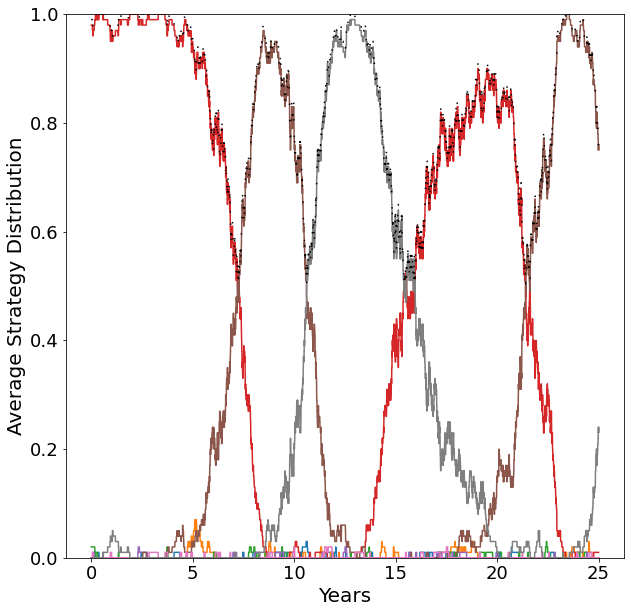

In [17]:
#Plot of average strategy distribution over time (averaged across simulations)

strategy_names = ['Farm', 'FarmMigrate', 'Farm+Share', 'FarmMigrate+Share', 'Farm+Ins', 'FarmMigrate+Ins', 'Farm+Share+Ins', 'FarmMigrate+Share+Ins']
#simulation_run = np.load('Alpha0.0_Moralis0.0_Drought0.5_Corr0.6_NoMigrate_frequencydist.npy', allow_pickle = True)
simulation_run = sim_frequency_dist
max_value = np.zeros((simulations, time))
avg_max_value = np.zeros(time)

local_variables = {key: [] for key in strategy_names}

avg_sim_time_distribution = {key: [] for key in strategy_names}

for var_name in strategy_names:
    
    local_variables[var_name] = np.zeros((simulations, time))
    for a in range(simulations):
        for t in range(time):
            local_variables[var_name][a,t] = simulation_run[a][t][var_name]
    
    avg_time_distribution = np.zeros(time)
    for t in range(time):
        avg_time_distribution[t] = np.average(local_variables[var_name][:,t])
    
    avg_sim_time_distribution[var_name] = avg_time_distribution


for t in range(time):
    for a in range(simulations):
        max_value[a][t] = max(simulation_run[a][t].values())
    avg_max_value[t] = np.average(max_value[:,t])

f, ax = plt.subplots(figsize=[10,10])
x = np.linspace(0, time / (4 * 2 * households), time)

labels = []

for key in strategy_names:
    if beta == 0:
        if 'Share' in key:
            equivalent = key.replace('+Share', '')
            labels.append('_')
            avg_sim_time_distribution[equivalent] += avg_sim_time_distribution[key]
            avg_sim_time_distribution[key] = np.zeros(time)
        else:
            labels.append(key)
            
    else:
        labels = strategy_names

for key, label in zip(strategy_names, labels):
    y = np.asarray(avg_sim_time_distribution[key])
    ax.plot(x, y, label = str(label))
    

            
ax.plot(x, avg_max_value+0.01, ls= (0, (1,10)), color='black', label='Max Value')
ax.set_ylim([0,1])
#ax.set_xlim([0,50])
ax.set_xlabel('Years', fontsize=20)
ax.set_ylabel('Average Strategy Distribution', fontsize=20)

plt.xticks(size=18)
plt.yticks(size=18)
#plt.legend(fontsize=18)
plt.show()

#plt.savefig(str(prefix) + '_strategies.png', bbox_inches='tight')

# Financial Restrictions Model

In [44]:
#Full model with formal insurance options and restrictions

#Loop through time steps
t1_start = process_time()
cycles = 200 #Time now represents 1 cropping cycle
ins_start = 30 #Time step when insurance is introduced
sim_frequency_dist = []
sim_strategies = []
sim_target_strategies = []
sim_savings = np.zeros(((simulations, cycles, households)))
sim_socutil = []
drought_status = []
p_index = np.zeros((simulations, cycles))
constraints = np.zeros(((simulations, cycles, households)))
household_incomes = np.zeros(((simulations, cycles, households)))
household_profits = np.zeros(((simulations, cycles, households)))



init_strategies = {'Farm': 0.475,
                    'FarmMigrate': 0.025,
                    'Farm+Share': 0.475,
                    'FarmMigrate+Share': 0.025}

adj_k, adj_scale = wei_adjust(mu_farm, farm_k, p_drought, objective_drought, max_farm)
mu_farm_drought, mu_farm_nd, uninsured_var, insured_var = farm_drought_0(adj_k, adj_scale, p_drought, max_farm)
non_drought, drought = weib_split(adj_k, adj_scale, p_drought, max_farm)
rem_mu, rem_sigma = lognorm_factors(mu_migrate, math.sqrt(var_migrate))
premium = p_drought * (mu_farm_nd - mu_farm_drought)
subsidy = subs_fraction * premium

random.seed(24)
for a in range(simulations):
    print(a)
    init_draw = np.zeros((cycles, households))
    drought_status = []
    t=0
    
    #Setting up droughts and incomes for a given simulation
    for c in range(cycles):
        p_index[a,c] = np.random.random()
        
        if p_index[a,c] < p_drought:
            drought_status.append('Drought')
        else:
            drought_status.append('No Drought')
            
        for i in range(households):
            init_draw[c,i] = weib_draw(drought, non_drought, p_index[a,c], p_drought) #Before adjusting for correlation
        
    #Generating a matrix of dimensions ((households, simulations)) of correlated incomes
    farm_draw = corr_income2(init_draw, p_cov, p_index[a,:], p_drought)
    farmincomematrix = farm_draw
    costs = {'Farm': cost_farm, 
            'FarmMigrate': cost_farm, 
            'Farm+Share': cost_farm, #Share contribution included in income_draw 
            'FarmMigrate+Share': cost_farm, 
            'Farm+Ins': cost_farm + premium - subsidy, 
            'FarmMigrate+Ins': cost_farm + eta * premium - subsidy, 
            'Farm+Share+Ins': cost_farm + premium - subsidy, 
            'FarmMigrate+Share+Ins': cost_farm + eta * premium - subsidy}

    #Seeding strategies based on average distribution without insurance
    strategy_names = ['Farm', 'FarmMigrate', 'Farm+Share', 'FarmMigrate+Share']
    yearly_strategies = []
    yearly_target_strategies = []
    initial_strategies = [] 
    
    initial_strategies, preferences = _init_seeded(households, strategy_names, init_strategies, pref_fraction, altruism_factor, k)
    yearly_strategies.append(initial_strategies)
    yearly_target_strategies.append(initial_strategies)
    frequency_dist = []
    frequency_dist.append(strategy_dist(yearly_strategies[-1], strategy_names, households)) 
    household_incomes[a,t,:] = income_draw(households, yearly_strategies[-1], rem_mu, rem_sigma, eta, p_drought, mu_farm_nd, mu_farm_drought, p_index[a,:], farmincomematrix, cost_farm, beta, t)
    consumption = np.zeros(households)
    for j in range(households):
        consumption[j] = max(consump_thres, (0.82 * household_incomes[a,0,j])) 
    
    #Profits_draw subtracts migration costs from profits if household hasn't already migrated
    household_profits[a,t,:] = profits_draw(households, yearly_strategies, household_incomes[a,t,:], costs, cost_migrate, consumption, t)
    sim_savings[a,t,:] += household_profits[a,t,:]
    
    for t in range(1, cycles):
        consumption = np.zeros(households)
        if t >= ins_start:
            strategy_names = ['Farm', 'FarmMigrate', 'Farm+Share', 'FarmMigrate+Share', 'Farm+Ins', 'FarmMigrate+Ins', 'Farm+Share+Ins', 'FarmMigrate+Share+Ins']

        strategies = yearly_strategies[-1]
        target_strategy = yearly_target_strategies[-1]
        
        for i in range(households):
            costs = {'Farm': cost_farm, 
            'FarmMigrate': cost_farm, 
            'Farm+Share': cost_farm, #Share contribution included in income_draw 
            'FarmMigrate+Share': cost_farm, 
            'Farm+Ins': cost_farm + premium - subsidy, 
            'FarmMigrate+Ins': cost_farm + eta * premium - subsidy, 
            'Farm+Share+Ins': cost_farm + premium - subsidy, 
            'FarmMigrate+Share+Ins': cost_farm + eta * premium - subsidy}
    
            altruism_factor = preferences[i][0]
            k = preferences[i][1]
            old_strategy = yearly_strategies[-1][i]            
            
            target_strategy[i] = fermi_calc(households, strategies, i, utility_function, strategy_names, risk_factor, frequency_dist, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, eta, mu_migrate, subsidy, uninsured_var, insured_var, var_migrate, beta, cost_farm, cost_migrate, p_drought, time_horizon, discount_rate, altruism_factor, max_altruism, k, sel_strength, mutation_rate)
            strategies[i], constraints[a,t,i] = fin_check(sim_savings[a,t-1,i], costs, target_strategy[i], old_strategy, cost_migrate)
            frequency_dist.append(strategy_dist(strategies, strategy_names, households))
            
        yearly_strategies.append(strategies)
        yearly_target_strategies.append(target_strategy) 
        household_incomes[a,t,:] = income_draw(households, strategies, rem_mu, rem_sigma, eta, p_drought, mu_farm_nd, mu_farm_drought, p_index[a,:], farmincomematrix, cost_farm, beta, t)
        
        for j in range(households):
            consumption[j] =  max(consump_thres, (0.82 * household_incomes[a,t,j]))
        household_profits[a,t,:] = profits_draw(households, yearly_strategies, household_incomes[a,t,:], costs, cost_migrate, consumption, t)
        sim_savings[a,t,:] = sim_savings[a,t-1,:] + household_profits[a,t,:]
    
    sim_socutil.append(collective_utility(strategy_names, frequency_dist, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, eta, mu_migrate, beta, cost_farm, cost_migrate, p_drought, 0, matching, time_horizon, discount_rate, uninsured_var, insured_var, var_migrate, rho_mig, households, p_cov, risk_factor))
    sim_frequency_dist.append(frequency_dist)
    sim_strategies.append(yearly_strategies)
    sim_target_strategies.append(yearly_target_strategies)


t1_stop = process_time()
print('Elapsed Time:', (t1_stop - t1_start) / 60)
prefix = 'Altruism' + str(altruism_factor) + '_Solidarity' + str(k) + '_Drought' + str(p_drought) + '_Corr' + str(p_cov) + '_Subs' + str(subs_fraction) + '_Restrictions'
np.save(str(prefix) + '_frequencydist.npy', sim_frequency_dist)
#np.save(str(prefix) + '_socutility.npy', sim_socutil)


0
1
2
3
4
5
6
7
8
9
Elapsed Time: 3.9848649500000004


# Simulation Results

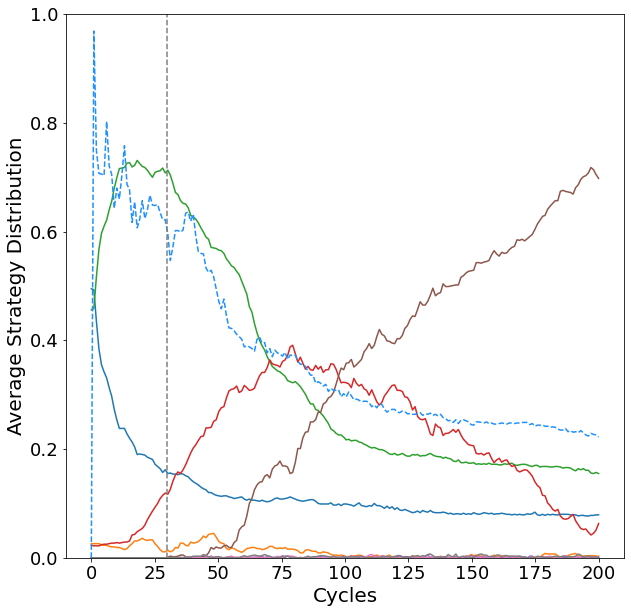

In [47]:
#Plot of average strategy distribution over time (averaged across simulations)

strategy_names = ['Farm', 'FarmMigrate', 'Farm+Share', 'FarmMigrate+Share', 'Farm+Ins', 'FarmMigrate+Ins', 'Farm+Share+Ins', 'FarmMigrate+Share+Ins']
time = cycles #Leave this in if running financial restrictions model
#simulation_run = np.load('Alpha0.0_Moralis0.0_Drought0.5_Corr0.6_NoMigrate_frequencydist.npy', allow_pickle = True)
simulation_run = sim_frequency_dist
max_value = np.zeros((simulations, time))
avg_max_value = np.zeros(time)

local_variables = {key: [] for key in strategy_names}

avg_sim_time_distribution = {key: [] for key in strategy_names}

for var_name in strategy_names:
    
    local_variables[var_name] = np.zeros((simulations, time))
    for a in range(simulations):
        for t in range(time):
            local_variables[var_name][a,t] = simulation_run[a][t*households][var_name]
    
    avg_time_distribution = np.zeros(time)
    for t in range(time):
        avg_time_distribution[t] = np.average(local_variables[var_name][:,t])
    
    avg_sim_time_distribution[var_name] = avg_time_distribution

    
    
sim_constrained = np.zeros((simulations,cycles))
avg_constrained = np.zeros(time)

for t in range(time):
    for a in range(simulations):
        max_value[a][t] = max(simulation_run[a][t*households].values())
        sim_constrained[a,t] = np.average(constraints[a,t,:])
    avg_max_value[t] = np.average(max_value[:,t])
    avg_constrained[t] = np.average(sim_constrained[:,t])
f, ax = plt.subplots(figsize=[10,10])
x = np.linspace(0, time, time)

labels = []

for key in strategy_names:
    if beta == 0:
        if 'Share' in key:
            equivalent = key.replace('+Share', '')
            labels.append('_')
            avg_sim_time_distribution[equivalent] += avg_sim_time_distribution[key]
            avg_sim_time_distribution[key] = np.zeros(time)
        else:
            labels.append(key)
            
    else:
        labels = strategy_names

for key, label in zip(strategy_names, labels):
    y = np.asarray(avg_sim_time_distribution[key])
    #if label == 'FarmMigrate+Share' or label == 'FarmMigrate+Ins':
    ax.plot(x, y, label = str(label))
    #else:
        #ax.plot(x,y)
    

            
#ax.plot(x, avg_max_value+0.01, ls= (0, (1,10)), color='black', label='Max Value')
ax.plot(x, avg_constrained, ls='--', color='dodgerblue', label='Fraction Constrained')
ax.set_ylim([0,1])
#ax.set_xlim([0,80])
ax.set_xlabel('Cycles', fontsize=20)
ax.set_ylabel('Average Strategy Distribution', fontsize=20)

plt.axvline(ins_start, label='Insurance Introduced', ls='--', color='grey')
plt.xticks(size=18)
plt.yticks(size=18)
#plt.legend(fontsize=18)
#plt.show()

plt.savefig(prefix + '_Restrictions_strategies.png', bbox_inches='tight')



# Other Plots

## Income Distribution for Given Drought Risk

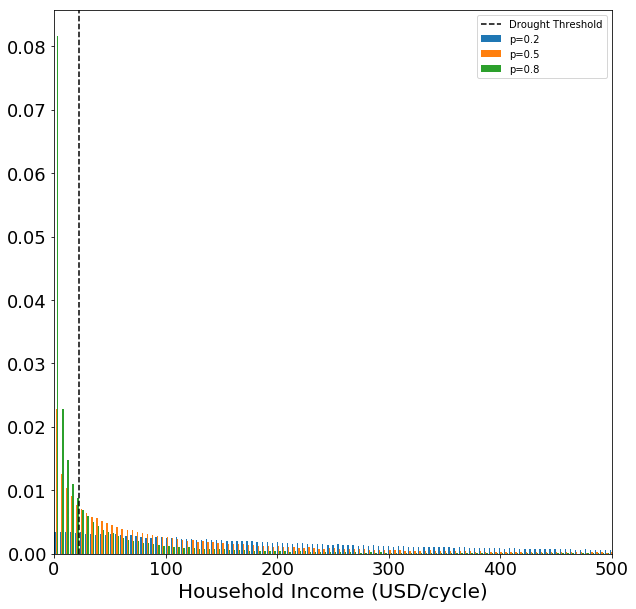

In [15]:
#Plotting Weibull distributions adjusted for drought risk

drought_risks = [0.2, 0.5, 0.8]
hist_array = []

for item in drought_risks:
    p_drought = item
    adj_k, adj_scale = wei_adjust(mu_farm, farm_k, p_drought, objective_drought, max_farm)

    base = np.random.weibull(adj_k, size=100000)

    dist = np.zeros(len(base))

    for i in range(len(base)):
        dist[i] = adj_scale * base[i]
    
    hist_array.append(dist)
    
n_bins = 1000
fig, axs = plt.subplots(1, 1, figsize=(10,10))

#for i in range(len(hist_array)):
    #print(len(hist_array[i]))

axs.hist(hist_array, bins = n_bins, density=True, label= ['p=0.2', 'p=0.5', 'p=0.8'])    
axs.set_xlim([0,500])
plt.xlabel('Household Income (USD/cycle)', fontsize=20)
plt.axvline(22.69, color='black', ls='--', label='Drought Threshold')
plt.xticks(size=18)
plt.yticks(size=18)
plt.legend()
plt.show()

#plt.savefig('DroughtRiskDistributions.png', bbox_inches='tight')


## Variance and Expected Income as Function of Participants

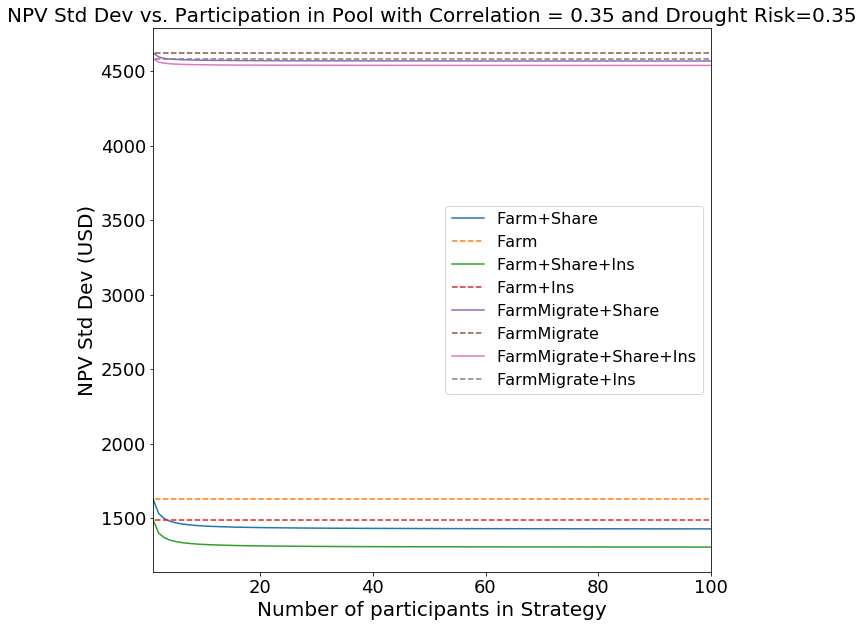

In [18]:
#Plotting variance of shared pool as a function of participants (varying strategies)

adj_k, adj_scale = wei_adjust(mu_farm, farm_k, p_drought, objective_drought, max_farm)
mu_farm_drought, mu_farm_nd, uninsured_var, insured_var = farm_drought_0(adj_k, adj_scale, p_drought, max_farm)
    
strategy_names = ['Farm', 'FarmMigrate', 'Farm+Share', 'FarmMigrate+Share', 'Farm+Ins', 'FarmMigrate+Ins', 'Farm+Share+Ins', 'FarmMigrate+Share+Ins']

x = np.linspace(0,households, households+1)

y = np.zeros(households+1)
y_0 = np.zeros(households+1)
#frequency_dist = {key: 0 for key in strategy_names}
#strategy='FarmMigrate+Share'
#baseline = 'FarmMigrate'

shared_strategies = ['Farm+Share', 'Farm+Share+Ins', 'FarmMigrate+Share', 'FarmMigrate+Share+Ins']
baseline_strategies = ['Farm', 'Farm+Ins', 'FarmMigrate', 'FarmMigrate+Ins']

y_var = {key : y for key in shared_strategies}
y0_var = {key: y_0 for key in baseline_strategies}


f, ax1 = plt.subplots(figsize=[10,10])

for strat, base in zip(shared_strategies, baseline_strategies):
    frequency_dist = {key: 0 for key in strategy_names}
    for i in range(len(x)):
        frequency_dist[strat] = x[i] / households
        stdevs = variance_calc(mu_farm, farm_k, p_drought, eta, uninsured_var, insured_var, var_migrate, beta, rho_mig, frequency_dist, households, p_cov, strategy_names, time_horizon, discount_rate)
        #print('Farm Std Dev:', stdevs[strat], stdevs[base])
        if 'Migrate' in strat:
            stdevs[strat] += math.sqrt(var_migrate)
        if 'Migrate' in base:
            stdevs[base] += math.sqrt(var_migrate)
            
        y_var[strat][i] = npv_calc(stdevs[strat], time_horizon, discount_rate) 
        y0_var[base][i] = npv_calc(stdevs[base], time_horizon, discount_rate)
    

    ax1.plot(x,y_var[strat], label=strat)
    ax1.plot(x,y0_var[base], ls='--', label=base)

ax1.set_ylabel('NPV Std Dev (USD)', size=20)
ax1.set_xlabel('Number of participants in Strategy', size=20)
ax1.set_xlim([1,households])
#ax1.set_ylim([5600, 6000])
#ax1.set_xlim([1,5])
plt.legend(fontsize=16)
plt.xticks(size=18)
plt.yticks(size=18)
plt.title('NPV Std Dev vs. Participation in Pool with Correlation = ' + str(p_cov) + ' and Drought Risk=' + str(p_drought), size=20)
plt.show()

#plt.savefig('PoolVariance_Drought0.2Corr0.1.png', bbox_inches='tight')
    

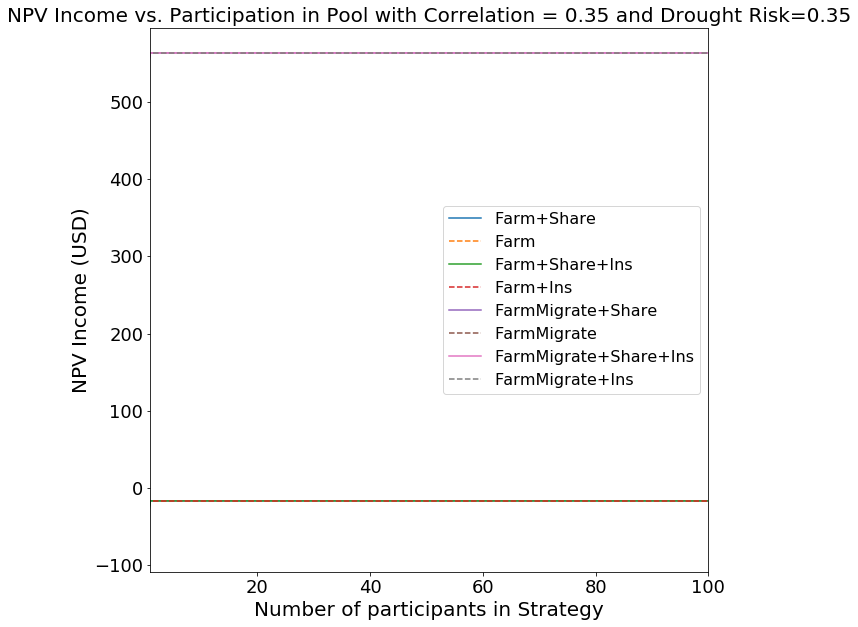

In [23]:
#Plotting Income of shared pool as a function of participants (varying strategies)

adj_k, adj_scale = wei_adjust(mu_farm, farm_k, p_drought, objective_drought, max_farm)
mu_farm_drought, mu_farm_nd, uninsured_var, insured_var = farm_drought_0(adj_k, adj_scale, p_drought, max_farm)

strategy_names = ['Farm', 'FarmMigrate', 'Farm+Share', 'FarmMigrate+Share', 'Farm+Ins', 'FarmMigrate+Ins', 'Farm+Share+Ins', 'FarmMigrate+Share+Ins']

x = np.linspace(0,households, households+1)

y = np.zeros(households+1)
y_0 = np.zeros(households+1)


shared_strategies = ['Farm+Share', 'Farm+Share+Ins', 'FarmMigrate+Share', 'FarmMigrate+Share+Ins']
baseline_strategies = ['Farm', 'Farm+Ins', 'FarmMigrate', 'FarmMigrate+Ins']

y_inc = {key : y for key in shared_strategies}
y0_inc = {key: y_0 for key in baseline_strategies}
incomes = {key: 0 for key in baseline_strategies}

f, ax1 = plt.subplots(figsize=[10,10])

for strat, base in zip(shared_strategies, baseline_strategies):
    frequency_dist = {key: 0 for key in strategy_names}
    for i in range(len(x)):
        frequency_dist[strat] = x[i] / households
        drought_incomes, nondrought_incomes = payoffs_calc(strategy_names, p_drought, mu_farm_nd, mu_farm_drought, eta, mu_migrate, beta, frequency_dist, matching, cost_farm, subsidy, time_horizon, 1, cost_migrate)
        
        incomes[strat] = p_drought * drought_incomes[strat] + (1 - p_drought) * nondrought_incomes[strat]
        incomes[base] = p_drought * drought_incomes[base] + (1 - p_drought) * nondrought_incomes[base]
        
        if 'Migrate' in strat:
            incomes[strat] += mu_migrate
        if 'Migrate' in base:
            incomes[base] += mu_migrate
        
        y_inc[strat][i] = incomes[strat]
        y0_inc[base][i] = incomes[base]
    

    ax1.plot(x,y_inc[strat], label=strat)
    ax1.plot(x,y0_inc[base], ls='--', label=base)
    
#ax1.plot(x, y_0, ls='--')
ax1.set_ylabel('NPV Income (USD)', size=20)
ax1.set_xlabel('Number of participants in Strategy', size=20)
ax1.set_xlim([1,households])
#ax1.set_ylim([-500, -750])
plt.legend(fontsize=16)
plt.xticks(size=18)
plt.yticks(size=18)
plt.title('NPV Income vs. Participation in Pool with Correlation = ' + str(p_cov) + ' and Drought Risk=' + str(p_drought), size=20)
plt.show()

#plt.savefig('PoolIncome_Drought0.2Corr0.1.png', bbox_inches='tight')

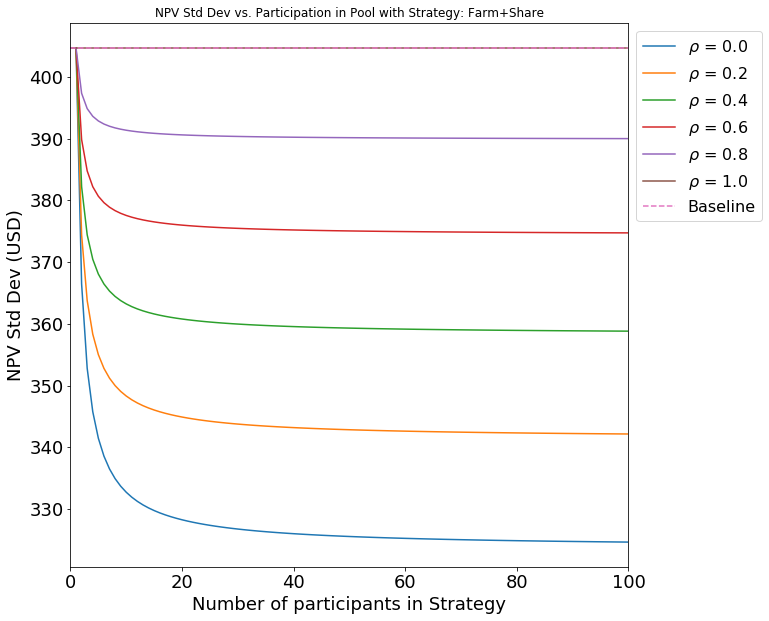

In [52]:
#Plotting variance of shared pool as a function of correlation between incomes

x = np.linspace(0,households, households+1)

y = np.zeros(households+1)
y_0 = np.zeros(households+1)
strategy='Farm+Share'
baseline = 'Farm'


rho = np.linspace(0, 1, 6)
keys = []
for i in range(len(rho)):
    keys.append(str(rho[i]))

y_dict = {key : y for key in keys}
y0_dict = {key: y_0 for key in keys}


f, ax1 = plt.subplots(figsize=[10,10])

for j, value in enumerate(keys):

    frequency_dist = {key: 0 for key in strategy_names}
    for i in range(len(x)):
        frequency_dist[strategy] = x[i] / households
        stdevs = variance_calc(mu_farm, farm_k, p_drought, eta, uninsured_var, insured_var, var_migrate, beta, rho_mig, frequency_dist, households, rho[j], strategy_names, time_horizon, discount_rate)
        y_dict[value][i] = npv_calc(stdevs[strategy], time_horizon, discount_rate)
        y0_dict[value][i] = npv_calc(stdevs[baseline], time_horizon, discount_rate)
    

    ax1.plot(x,y_dict[value], label= r'$\rho$ = ' + value[0:3])
ax1.plot(x,y0_dict[value], ls='--', label='Baseline')
#ax1.plot(x, y_0, ls='--')
ax1.set_ylabel('NPV Std Dev (USD)', size=18)
ax1.set_xlabel('Number of participants in Strategy', size=18)
ax1.set_xlim([0,100])
#ax1.set_ylim([120, 150])
plt.legend(fontsize=16, bbox_to_anchor = (1,1), loc='upper left')
plt.xticks(size=18)
plt.yticks(size=18)
plt.title('NPV Std Dev vs. Participation in Pool with Strategy: ' + str(strategy))
plt.show()

#plt.savefig('PoolVariance_FarmShare_Beta0.1.png', bbox_inches='tight')
    


In [ ]:
#Variance as a function of drought risk

p_drought = np.linspace(0.1,0.9,9)
rho = [0.1, 0.35, 0.6]
strategy_names = ['Farm', 'FarmMigrate', 'Farm+Share', 'FarmMigrate+Share', 'Farm+Ins', 'FarmMigrate+Ins', 'Farm+Share+Ins', 'FarmMigrate+Share+Ins']
target_strategies = ['FarmMigrate', 'FarmMigrate+Ins']

for r in rho:
    target_strategies.append('FarmMigrate+Share_' + str(r))
    
colors = {key: 'red' for key in target_strategies}
colors['FarmMigrate'] = 'gray'
colors['FarmMigrate+Ins'] = 'black'

lines = {key: 'solid' for key in target_strategies}
lines['FarmMigrate+Share_0.35'] = 'dashed'
lines['FarmMigrate+Share_0.6'] = 'dotted'

frequency_dist = {key: 0 for key in strategy_names}
std_array = {key: [] for key in target_strategies}
income_array = {key: [] for key in target_strategies}

frequency_dist['FarmMigrate+Share'] = 0.1
frequency_dist['FarmMigrate'] = 1 - frequency_dist['FarmMigrate+Share']

for p in p_drought:
    print(p)
    adj_k, adj_scale = wei_adjust(mu_farm, farm_k, p, objective_drought, max_farm)
    mu_farm_drought, mu_farm_nd, uninsured_var, insured_var = farm_drought_0(adj_k, adj_scale, p, max_farm)
    stdevs = variance_calc(mu_farm, farm_k, p, eta, uninsured_var, insured_var, var_migrate, beta, rho_mig, frequency_dist, households, rho[0], strategy_names, time_horizon, discount_rate)
    #incomes = income_calc(strategy_names, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, eta, mu_migrate, beta, 1, frequency_dist, cost_farm, cost_migrate, p, subsidy, matching, time_horizon, discount_rate)[0]
    incomes = payoffs_calc(strategy_names, p_drought, mu_farm_nd, mu_farm_drought, eta, mu_migrate, beta, frequency_dist, matching, cost_farm, subsidy, time_horizon, 1, cost_migrate)

    for item in target_strategies:
        if 'Share' not in item:
            std_array[item].append(npv_calc(stdevs[item], time_horizon, discount_rate))
            income_array[item].append(npv_calc(incomes[item], time_horizon, discount_rate))
            
    for i in range(len(rho)):
        share_std = variance_calc(mu_farm, farm_k, p, eta, uninsured_var, insured_var, var_migrate, beta, rho_mig, frequency_dist, households, rho[i], strategy_names, time_horizon, discount_rate)['FarmMigrate+Share']        
        #share_income = income_calc(strategy_names, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, eta, mu_migrate, beta, 1, frequency_dist, cost_farm, cost_migrate, p, subsidy, matching, time_horizon, discount_rate)[0]['FarmMigrate+Share']
        share_income = payoffs_calc(strategy_names, p_drought, mu_farm_nd, mu_farm_drought, eta, mu_migrate, beta, frequency_dist, matching, cost_farm, subsidy, time_horizon, 1, cost_migrate)['FarmMigrate+Share']

        std_array['FarmMigrate+Share_' + str(rho[i])].append(npv_calc(share_std, time_horizon, discount_rate))
        income_array['FarmMigrate+Share_' + str(rho[i])].append(npv_calc(share_income, time_horizon, discount_rate))

f, ax1 = plt.subplots(figsize=[10,10])

for item in target_strategies:
    ax1.plot(p_drought, std_array[item], label=item, color=colors[item], ls=lines[item])

ax1.set_xlabel('Drought Risk', fontsize=20)
ax1.set_ylabel('Standard Deviation (USD)', fontsize=20)

plt.legend(fontsize=16, loc='upper right')
plt.xticks(size=18)
plt.yticks(size=18)

plt.show()

#plt.savefig('Variance_DroughtRisk.png', bbox_inches='tight')




0.1


In [28]:
#Plot of expected income as a function of drought risk

f, ax1 = plt.subplots(figsize=[10,10])

ax1.plot(p_drought, income_array['FarmMigrate'], label='FarmMigrate', color=colors['FarmMigrate'], ls='solid')
ax1.plot(p_drought, income_array['FarmMigrate+Ins'], label='FarmMigrate+Ins', color=colors['FarmMigrate+Ins'], ls='dashed')
ax1.plot(p_drought, income_array['FarmMigrate+Share_0.1'], label='FarmMigrate+Share', color=colors['FarmMigrate+Share_0.1'], ls='dotted')


ax1.set_xlabel('Drought Risk', fontsize=20)
ax1.set_ylabel('Expected Income (USD/cycle)', fontsize=20)

plt.legend(fontsize=16, loc='upper right')
plt.xticks(size=18)
plt.yticks(size=18)

plt.show()

#plt.savefig('ExpectedIncome_DroughtRisk.png', bbox_inches='tight')

In [49]:
#Plot of up-front costs as a function of drought risk
strategy_names = ['Farm', 'FarmMigrate', 'Farm+Share', 'FarmMigrate+Share', 'Farm+Ins', 'FarmMigrate+Ins', 'Farm+Share+Ins', 'FarmMigrate+Share+Ins']
p_drought = np.linspace(0.1, 0.9, 9)
baseline = np.zeros(len(p_drought))
baseline_var = np.zeros(len(p_drought))
share = np.zeros(len(p_drought))
share_var = np.zeros(len(p_drought))
ins = np.zeros(len(p_drought))
ins_var = np.zeros(len(p_drought))
both = np.zeros(len(p_drought))
both_var = np.zeros(len(p_drought))

frequency_dist = []
equal_dist = {key : 1.0 for key in strategy_names}
frequency_dist.append(equal_dist)

for i, p in enumerate(p_drought):
    adj_k, adj_scale = wei_adjust(mu_farm, farm_k, p, objective_drought, max_farm)
    mu_farm_drought, mu_farm_nd, uninsured_var, insured_var = farm_drought_0(adj_k, adj_scale, p, max_farm)    
    
    costs = income_calc(strategy_names, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, eta, mu_migrate, beta, 1, frequency_dist[-1], cost_farm, cost_migrate, p, subsidy, matching, time_horizon, discount_rate)[1]
    baseline[i] = npv_calc(np.full(time_horizon, costs['FarmMigrate'] * losav),time_horizon, discount_rate)
    share[i] = npv_calc(np.full(time_horizon, costs['FarmMigrate+Share'] * losav - beta * eta * (p * mu_farm_drought + (1 - p) * mu_farm_nd)), time_horizon, discount_rate)
    ins[i] = npv_calc(np.full(time_horizon, costs['FarmMigrate+Ins'] * losav - p * eta * (mu_farm_nd - mu_farm_drought)), time_horizon, discount_rate)
    both[i] = npv_calc(np.full(time_horizon, costs['FarmMigrate+Share+Ins'] * losav - eta * (p * (mu_farm_nd - mu_farm_drought) + beta * mu_farm_nd)), time_horizon, discount_rate)
    
    std = variance_calc(mu_farm, farm_k, p, eta, uninsured_var, insured_var, var_migrate, beta, rho_mig, frequency_dist[-1], households, p_cov, strategy_names, time_horizon, discount_rate)
    baseline_var[i] = npv_calc(std['FarmMigrate'], time_horizon, discount_rate)
    share_var[i] = npv_calc(std['FarmMigrate+Share'], time_horizon, discount_rate)
    ins_var[i] = npv_calc(std['FarmMigrate+Ins'], time_horizon, discount_rate)
    both_var[i] = npv_calc(std['FarmMigrate+Share+Ins'], time_horizon, discount_rate)

f, ax1 = plt.subplots(figsize=[10,10])
ax1.plot(p_drought, share-baseline, label='Costs', color='red')
ax1.plot(p_drought, ins-baseline, color='brown')
ax1.plot(p_drought, both-baseline, color='grey')
ax1.plot(p_drought, risk_factor * (baseline_var - ins_var), ls = '--', label='Avoided Variance', color='brown')
ax1.plot(p_drought, risk_factor * (baseline_var - share_var), ls = '--', color='red')
ax1.plot(p_drought, risk_factor * (baseline_var - both_var), ls = '--', color='grey')

ax1.set_xlabel('Drought Risk', fontsize=20)
ax1.set_ylabel('Utils compared to FarmMigrate Baseline', fontsize=20)

plt.legend(fontsize=16)
plt.xticks(size=18)
plt.yticks(size=18)

#plt.show()

plt.savefig('UpfrontCosts_AvoidedVariance_losav1.png', bbox_inches='tight')



### Self-Reinforcing Strategies

In [32]:
#Plot of utility difference between 100% combined risk management and 1 defector for different drought values
strategy_names = ['Farm', 'FarmMigrate', 'Farm+Share', 'FarmMigrate+Share', 'Farm+Ins', 'FarmMigrate+Ins', 'Farm+Share+Ins', 'FarmMigrate+Share+Ins']
households = 100

p = np.arange(0.1, 1.0, 0.2)
#rho = [0.1, 0.35, 0.5]
rho = [0.35]
ins_temptation = np.zeros((len(rho), len(p)))
share_temptation = np.zeros((len(rho), len(p)))
ins_share_invasion = np.zeros((len(rho), len(p)))
combined_share_invasion = np.zeros((len(rho), len(p)))
share_ins_invasion = np.zeros((len(rho), len(p)))
combined_ins_invasion = np.zeros((len(rho), len(p)))


for j, p_cov in enumerate(rho):
    print(p_cov)
    for i, p_drought in enumerate(p):
        adj_k, adj_scale = wei_adjust(mu_farm, farm_k, p_drought, objective_drought, max_farm)
        mu_farm_drought, mu_farm_nd, uninsured_var, insured_var = farm_drought_0(adj_k, adj_scale, p_drought, max_farm)

        #expected_dist = []
        #combined_dist = {key: 0 for key in strategy_names}
        #combined_dist['FarmMigrate+Share+Ins'] = 1.0
        #expected_dist.append(combined_dist)
        #combined_util = utility_select(utility_function, strategy_names, risk_factor, expected_dist, 'FarmMigrate+Share+Ins', 'FarmMigrate+Share+Ins', households, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, eta, mu_migrate, subsidy, matching, uninsured_var, insured_var, var_migrate, p_cov, rho_mig, beta, cost_farm, cost_migrate, p_drought, time_horizon, discount_rate, altruism_factor, max_altruism, k)[1]
       
        expected_dist = []
        combined_dist = {key: 0 for key in strategy_names}
        combined_dist['FarmMigrate+Share+Ins'] = 1.0
        expected_dist.append(combined_dist)
        combined_util, share_util = utility_select(utility_function, strategy_names, risk_factor, expected_dist, 'FarmMigrate+Share+Ins', 'FarmMigrate+Share', households, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, eta, mu_migrate, subsidy, matching, uninsured_var, insured_var, var_migrate, p_cov, rho_mig, beta, cost_farm, cost_migrate, p_drought, time_horizon, discount_rate, altruism_factor, max_altruism, k)

        expected_dist = []
        combined_dist = {key: 0 for key in strategy_names}
        combined_dist['FarmMigrate+Share+Ins'] = 1.0
        expected_dist.append(combined_dist)
        ins_util = utility_select(utility_function, strategy_names, risk_factor, expected_dist, 'FarmMigrate+Share+Ins', 'FarmMigrate+Ins', households, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, eta, mu_migrate, subsidy, matching, uninsured_var, insured_var, var_migrate, p_cov, rho_mig, beta, cost_farm, cost_migrate, p_drought, time_horizon, discount_rate, altruism_factor, max_altruism, k)[1]

        expected_dist = []
        combined_dist = {key: 0 for key in strategy_names}
        combined_dist['FarmMigrate+Share'] = 1.0
        expected_dist.append(combined_dist)
        fullshare_util, ins_invasion = utility_select(utility_function, strategy_names, risk_factor, expected_dist, 'FarmMigrate+Share', 'FarmMigrate+Ins', households, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, eta, mu_migrate, subsidy, matching, uninsured_var, insured_var, var_migrate, p_cov, rho_mig, beta, cost_farm, cost_migrate, p_drought, time_horizon, discount_rate, altruism_factor, max_altruism, k)
        
        expected_dist = []
        combined_dist = {key: 0 for key in strategy_names}
        combined_dist['FarmMigrate+Share'] = 1.0
        expected_dist.append(combined_dist)
        combined_share_temptation = utility_select(utility_function, strategy_names, risk_factor, expected_dist, 'FarmMigrate+Share', 'FarmMigrate+Share+Ins', households, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, eta, mu_migrate, subsidy, matching, uninsured_var, insured_var, var_migrate, p_cov, rho_mig, beta, cost_farm, cost_migrate, p_drought, time_horizon, discount_rate, altruism_factor, max_altruism, k)[1]
        
    
        expected_dist = []
        combined_dist = {key: 0 for key in strategy_names}
        combined_dist['FarmMigrate+Ins'] = 1.0
        expected_dist.append(combined_dist)
        share_invasion, ins_baseline = utility_select(utility_function, strategy_names, risk_factor, expected_dist, 'FarmMigrate+Ins', 'FarmMigrate+Share', households, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, eta, mu_migrate, subsidy, matching, uninsured_var, insured_var, var_migrate, p_cov, rho_mig, beta, cost_farm, cost_migrate, p_drought, time_horizon, discount_rate, altruism_factor, max_altruism, k)
        
        expected_dist = []
        combined_dist = {key: 0 for key in strategy_names}
        combined_dist['FarmMigrate+Ins'] = 1.0
        expected_dist.append(combined_dist)
        combined_ins_temptation = utility_select(utility_function, strategy_names, risk_factor, expected_dist, 'FarmMigrate+Ins', 'FarmMigrate+Share+Ins', households, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, eta, mu_migrate, subsidy, matching, uninsured_var, insured_var, var_migrate, p_cov, rho_mig, beta, cost_farm, cost_migrate, p_drought, time_horizon, discount_rate, altruism_factor, max_altruism, k)[1]
        
    
        share_temptation[j,i] = share_util - combined_util
        ins_temptation[j,i] = ins_util - combined_util
        
        ins_share_invasion[j,i] = ins_invasion - fullshare_util
        #combined_share_invasion[j,i] = combined_share_temptation / fullshare_util
        
        #share_ins_invasion[j,i] = share_invasion / ins_baseline
        #combined_ins_invasion[j,i] = combined_ins_temptation / ins_baseline



0.35
63.2693905423875
2500
63.12441859093987
2500
63.47017437786035
2500
63.10004619564615
2500
63.17452353167979
2500


In [33]:
adj_k, adj_scale = wei_adjust(mu_farm, farm_k, p_drought, objective_drought, max_farm)
mu_farm_drought, mu_farm_nd, uninsured_var, insured_var = farm_drought_0(adj_k, adj_scale, p_drought, max_farm)

premium = p_drought * (mu_farm_nd - mu_farm_drought)
premium

63.14889327101692
2500


173.73910427706878

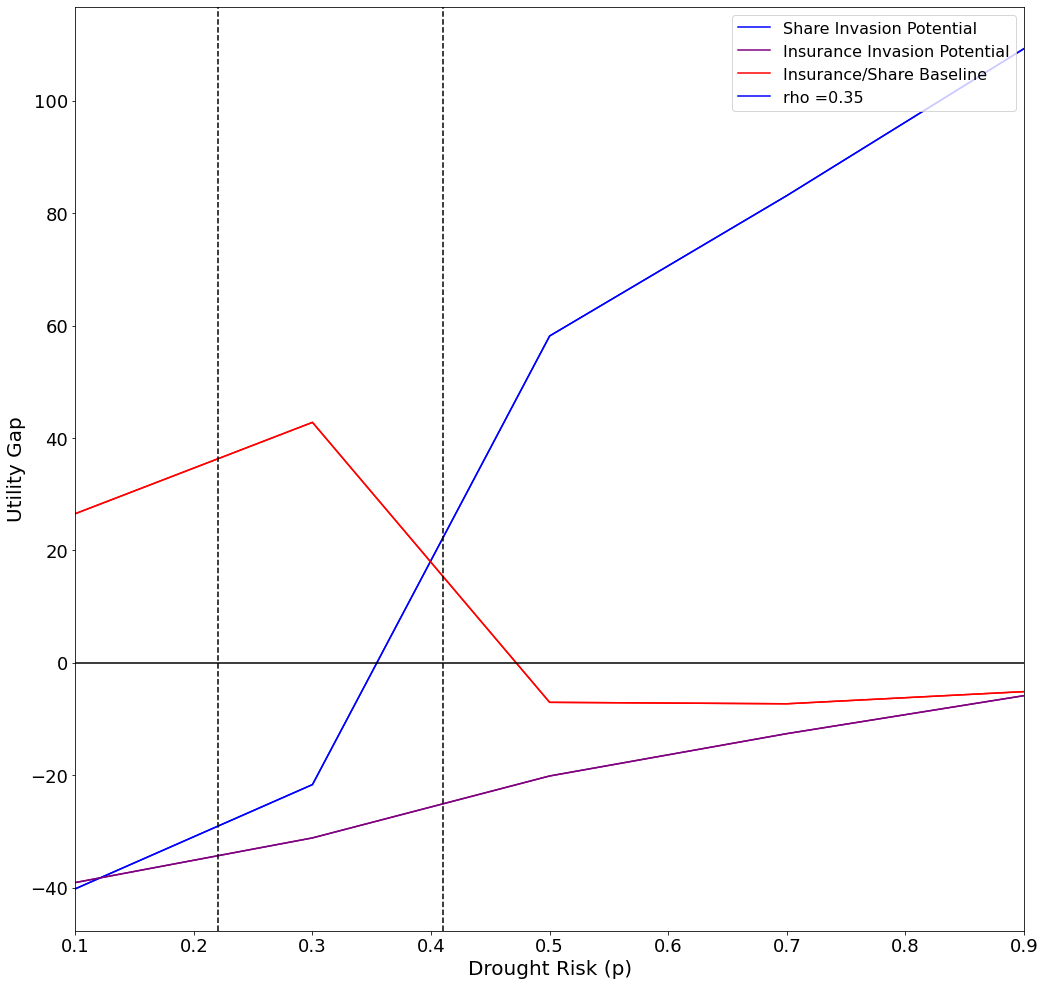

In [37]:
f, ax1 = plt.subplots(figsize=[17,17])

styles = ['-', '-.', '--']
for j in range(len(rho)):
    if j == 0:
        ax1.plot(p, share_temptation[j,:], label='Share Invasion Potential', color='blue', ls=styles[j])
        ax1.plot(p, ins_temptation[j,:], label='Insurance Invasion Potential', color = 'purple', ls=styles[j])
        ax1.plot(p, ins_share_invasion[j,:], label='Insurance/Share Baseline',color='red', ls=styles[j])
        #ax1.plot(p, combined_share_invasion[j,:], label='Combined/Share Baseline', ls=styles[j])
        #ax1.plot(p, share_ins_invasion[j,:], label='Share/Insurance Baseline', ls=styles[j])
        #ax1.plot(p, combined_ins_invasion[j,:], label='Combined/Insurance Baseline', ls=styles[j])

    ax1.plot(p, share_temptation[j,:], color='blue', ls=styles[j], label = 'rho =' + str(rho[j]))
    ax1.plot(p, ins_temptation[j,:], color='purple', ls=styles[j])
    ax1.plot(p, ins_share_invasion[j,:], color='red',ls=styles[j])
    #ax1.plot(p, combined_share_invasion[j,:], label='Combined/Share Baseline', ls=styles[j])
    #ax1.plot(p, share_ins_invasion[j,:], label='Share/Insurance Baseline', ls=styles[j])
    #ax1.plot(p, combined_ins_invasion[j,:], label='Combined/Insurance Baseline', ls=styles[j])


ax1.set_xlabel('Drought Risk (p)', fontsize=20)
ax1.set_ylabel('Utility Gap', fontsize=20)
ax1.set_xlim([0.1,0.9])
#ax1.set_ylim([0.9, 1.1])
plt.axhline(0, color='black')
plt.axvline(0.22, color='black', ls='--')
plt.axvline(0.41, color='black', ls='--')
#plt.text(0.1, 200, 'Co-Existence', size=20, color='purple')
#plt.text(0.3, 200, 'Insurance', size=20, color='red')
#plt.text(0.7, 150, 'Revenue-Sharing', size=20, color='blue')





plt.legend(fontsize=16, loc='upper right')
plt.xticks(size=18)
plt.yticks(size=18)

plt.show()

#plt.savefig('Self-Reinforcing_Plot.png', bbox_inches='tight')

## Gradient Plots

In [146]:
#Pairwise Invasability Plot featuring two strategies
# To Do: if one of strategy distributions = 0, check if gradient leads outside of boundaries. If so, adjust
strategy_names = ['Farm', 'FarmMigrate', 'Farm+Share', 'FarmMigrate+Share', 'Farm+Ins', 'FarmMigrate+Ins', 'Farm+Share+Ins', 'FarmMigrate+Share+Ins']
strategy_x = 'FarmMigrate+Share'
strategy_y = 'FarmMigrate+Ins'
strategy_z = 'FarmMigrate+Share+Ins'

adj_k, adj_scale = wei_adjust(mu_farm, farm_k, p_drought, objective_drought, max_farm)
mu_farm_drought, mu_farm_nd, uninsured_var, insured_var = farm_drought_0(adj_k, adj_scale, p_drought, max_farm)
premium = p_drought * (mu_farm_nd - mu_farm_drought)
subsidy = subs_fraction * premium
steps = 21

x = np.linspace(0.0,1,21)
y = np.linspace(0.0,1,21)

max_value = []

x_gap = np.zeros((len(y), len(x)))
y_gap = np.zeros((len(y), len(x)))

x_grad = np.zeros((len(y), len(x)))
y_grad = np.zeros((len(y), len(x)))

max_util = np.zeros((len(y), len(x)))
social_util = np.zeros((len(y), len(x)))

#Here, j should represent x-position, and i represents y-position
for i in range(len(y)):
    
    max_col = []
    
    
    for j in range(len(x)):
        
        
        if (x[j] + y[i]) <= 1:
            utilities = {key : 0 for key in strategy_names} 
            
            
            for strategy in strategy_names:
                frequency = []
                distribution = {key : 0 for key in strategy_names}
                distribution[strategy_x] = x[j]
                distribution[strategy_y] = y[i]
                distribution[strategy_z] = 1 - distribution[strategy_x] - distribution[strategy_y]
                frequency.append(distribution)
                utilities[strategy] = utility_select(utility_function, strategy_names, risk_factor, frequency, strategy_x, strategy, households, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, eta, mu_migrate, subsidy, matching, uninsured_var, insured_var, var_migrate, p_cov, rho_mig, beta, cost_farm, cost_migrate, p_drought, time_horizon, discount_rate, altruism_factor, max_altruism, k)[1]
            
            value, key = max(zip(utilities.values(), utilities.keys()))
            max_col.append(key)
            max_util[i,j] = value
            
            dist_vect = list(distribution.values())
            util_vect = list(utilities.values())
            social_util[i,j] = np.dot(dist_vect, util_vect)
            
            x_gap[i,j] = (utilities[strategy_x] - utilities[strategy_z]) / np.abs(utilities[strategy_x]) #Gradient should be utilities[strategy_x] for i + 1/20,
            y_gap[i,j] = (utilities[strategy_y] - utilities[strategy_z]) / np.abs(utilities[strategy_y]) #Gradient should be utilities[strategy_y] for j + 1/20 - utilities[j]
            
            if j == 0 and x_gap[i,j] < 0:
                x_gap[i,j] = 0
 
            elif i == 0 and y_gap[i,j] < 0:
                y_gap[i,j] = 0
  
                
            elif (x[j] + y[i] == 1):
            
                # If gradient is positive in both directions, figure out gradient along y = -x line
                if x_gap[i,j] > 0 and y_gap[i,j] > 0:
                    x_gap[i,j] = (utilities[strategy_x] - utilities[strategy_y]) / np.abs(utilities[strategy_x])
                    y_gap[i,j] = (utilities[strategy_y] - utilities[strategy_x]) / np.abs(utilities[strategy_y])

                else:
                    if x_gap[i,j] > 0: 
                        x_gap[i,j] = 0
                    
                    if y_gap[i,j] > 0:
                        y_gap[i,j] = 0

        
            x_grad[i,j] = x_gap[i,j] / (np.abs(x_gap[i,j]) + np.abs(y_gap[i,j]))
            y_grad[i,j] = y_gap[i,j] / (np.abs(x_gap[i,j]) + np.abs(y_gap[i,j]))

        else:
            max_col.append('')
            x_grad[i,j] = 0
            y_grad[i,j] = 0
            social_util[i,j] = np.nan
            
            
    
    max_value.append(max_col)
    



63.35394196478818
2500


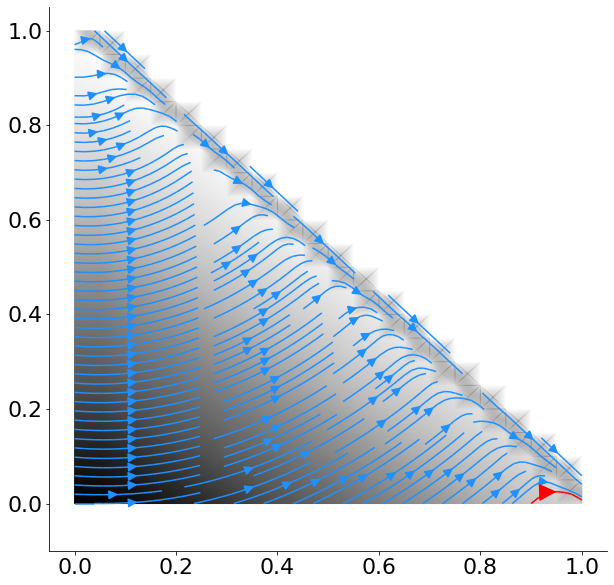

In [100]:
#Plot
X, Y = np.meshgrid(x, y)

strategy_dict = {'Farm': 0, 'Farm+Share': 1, 'Farm+Ins': 2, 'Farm+Share+Ins': 3, 'FarmMigrate': 4, 'FarmMigrate+Share': 5, 'FarmMigrate+Ins': 6, 'FarmMigrate+Share+Ins': 7, '': 8}

level_labels=[]
bounds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
        
f, ax = plt.subplots(figsize=[10,10])

c = plt.pcolormesh(X, Y, social_util, shading='gouraud', cmap='Greys')
stream_points = [[0.9,0.00]]
ax.streamplot(X, Y, x_grad, y_grad, color='dodgerblue', arrowstyle='simple', arrowsize = 1.5, maxlength=0.5, density=(1.75, 1.75))
ax.streamplot(X, Y, x_grad, y_grad, color='red', arrowstyle='simple', arrowsize=3, start_points = stream_points, density=(1.75,1.75))
#ax.plot(0.0, 1.0, 'ro', markersize=20)

#ax.quiver(X, Y, x_grad, y_grad, scale=40)

ax.set_ylim([-0.1,1.05])
ax.set_xlim([-0.05,1.05])
#ax.set_xlabel('Proportion Adopting ' + str(strategy_x), size=20)
#ax.set_ylabel('Proportion Adopting ' + str(strategy_y), size=20)

#To take off frame
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
#ax.spines['left'].set_visible(False)

#plt.text(-0.05, -0.05, 'Combined', size=30)
#plt.text(0.75, -0.05, 'Revenue-Sharing Only', size=30)
#plt.text(0.0, 1.02, 'Insurance Only', size=30)

plt.xticks(size=22)
plt.yticks(size=22)
#plt.legend('Utility')
plt.show()

prefix = 'Alpha' + str(altruism_factor) + '_Moralis' + str(k) + '_Drought' + str(p_drought) + '_Corr' + str(p_cov)
#plt.savefig(prefix + '_Gradient_nolabels_notext.png', bbox_inches='tight')
#plt.savefig('Dissertation_Gradient_HighProsociality.png', bbox_inches='tight')


## Ternary Plots

In [122]:
def simplex2DStream2(X, Y, x_grad, y_grad, fig, ax):
    name_x = 'S1'
    name_y = 'S2'
    name_z = 'S3'

    r0=np.array([0,0])
    r1=np.array([1,0])
    r2=np.array([1/2.,np.sqrt(3)/2.])

    corners =np.array([r0,r1,r2])
    triangle = tri.Triangulation(corners[:, 0], corners[:, 1])
    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=5)
    trimesh_fine = refiner.refine_triangulation(subdiv=5)
    
    X_pos = X + 0.5*Y
    Y_pos = np.sqrt(3)/2*Y
    x_grad2 = x_grad + 0.5*y_grad
    y_grad2 = y_grad * np.sqrt(3)/2
    epsilon = 0.02 #Extra buffer to allow gradient on edges to show up
    mask = ((Y_pos > X_pos *np.sqrt(3) + epsilon) | (Y_pos > -X_pos * np.sqrt(3) + np.sqrt(3) + epsilon))

    x_grad2[mask] = np.nan

    

    #plt.text(-0.05, 0.05, str(name_z), size=25)
    #plt.text(1.01, 0.05, str(name_x), size=25)
    #plt.text(0.4, np.sqrt(3)/2-0.05, str(name_y), size=25)
    ax.quiver(X_pos,Y_pos,x_grad2,y_grad2, 
                  linewidth=2.0, 
                  minlength=0.01,
                  color="b")
    
    #ax.streamplot(X,Y,x_grad2,y_grad2, 
                  #arrowsize=3.0, 
                  #density=1.5, 
                  #linewidth=2.0, 
                  #arrowstyle='->', 
                  #minlength=0.1,
                  #color="r")

    ax.triplot(triangle,linewidth=1.0,color="black")

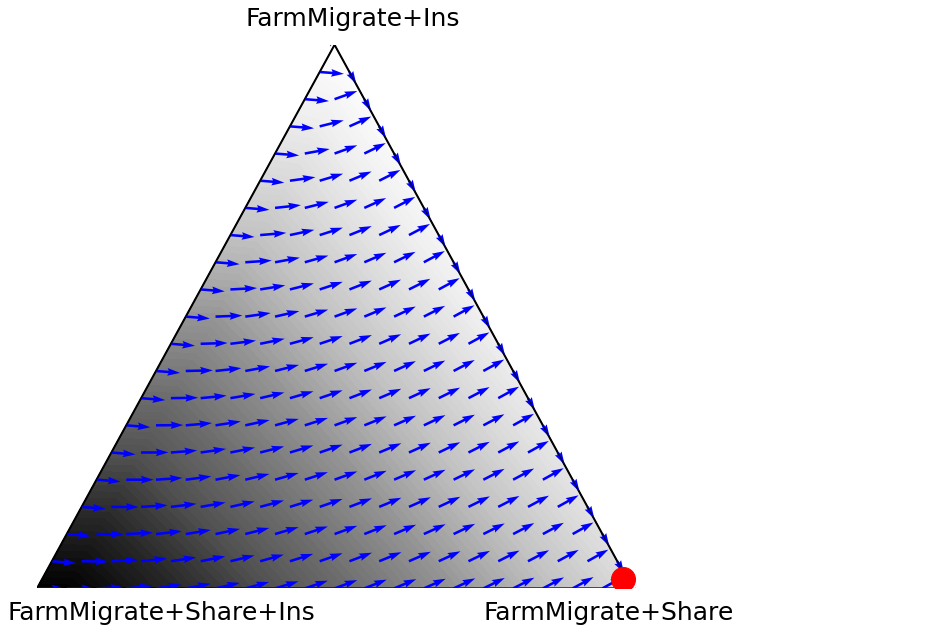

In [147]:
import matplotlib.tri as tri



r0=np.array([0,0])
r1=np.array([1,0])
r2=np.array([1/2.,np.sqrt(3)/2.])
corners =np.array([r0,r1,r2])
triangle = tri.Triangulation(corners[:, 0], corners[:, 1])
refiner = tri.UniformTriRefiner(triangle)
trimesh = refiner.refine_triangulation(subdiv=5)
trimesh_fine = refiner.refine_triangulation(subdiv=5)

fig,ax=plt.subplots()

#mask = X+Y < 1.0

XX = X + 0.5*Y
YY = np.sqrt(3)/2*Y

#x_grad2 = x_grad + 0.5*y_grad
#y_grad2 = y_grad * np.sqrt(3)/2

#Annotating Plot
plt.text(-0.05, -0.05, str(strategy_z), size=25)
plt.text(0.75, -0.05, str(strategy_x), size=25)
plt.text(0.35, np.sqrt(3)/2+0.03, str(strategy_y), size=25)

c = plt.contourf(XX, YY, social_util,100, cmap='Greys')
ax.triplot(triangle,linewidth=2.0,color="black")

simplex2DStream2(X, Y, x_grad, y_grad, fig, ax)



#Highlighting Equilibrium Point
ax.plot(0.985, 0.015,'ro',markersize=24)

fig.set_size_inches(16, 10)
plt.axis('off')
#plt.show()
prefix = 'Altruism' + str(altruism_factor) + '_Moralis' + str(k) + '_Drought' + str(p_drought) + '_Corr' + str(p_cov)
plt.savefig(str(prefix) + '_Triangle.png', bbox_inches='tight')

In [55]:
adj_k, adj_scale = wei_adjust(mu_farm, farm_k, p_drought, objective_drought, max_farm)
mu_farm_drought, mu_farm_nd, uninsured_var, insured_var = farm_drought_0(adj_k, adj_scale, p_drought, max_farm)
premium = p_drought * (mu_farm_nd - mu_farm_drought)

dividend = (premium * 0.04 - premium * 0.0) * 100 * 2
print(premium * 0.04 - premium * 0.0)
print(dividend)

expected_income = p_drought * mu_farm_drought + (1-p_drought) * mu_farm_nd
total_ag_income = expected_income * 100 * 2

dividend/total_ag_income

2.456370799735026
491.27415994700516


0.00890349671592979

In [58]:
print(expected_income)
print(total_ag_income)

275.8883254643294
55177.66509286588


[0 1 2]


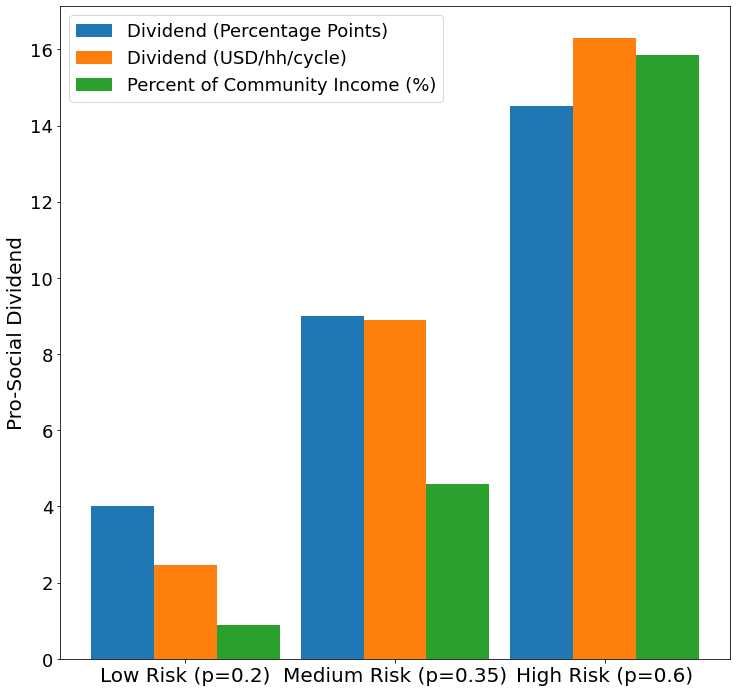

In [20]:
subs_differential = [4.0, 9.0, 14.5]
dividend = [2.46,8.90,16.31]
income_prop = [0.89,4.6,15.84]
xpos=np.arange(0,3,1)
print(xpos)
f, ax = plt.subplots(figsize=[12,12])
ax.bar(xpos-0.3, subs_differential, width=0.3, label='Dividend (Percentage Points)')
ax.bar(xpos, dividend, width=0.3, label='Dividend (USD/hh/cycle)')
ax.bar(xpos+0.3, income_prop, width=0.3, label='Percent of Community Income (%)')
ax.set_ylabel('Pro-Social Dividend', fontsize=20)

plt.xticks([r for r in sorted(xpos)], ['Low Risk (p=0.2)', 'Medium Risk (p=0.35)', 'High Risk (p=0.6)'], rotation = 0, fontsize=20)
plt.yticks(size=18)
plt.legend(fontsize=18)
#plt.show()

plt.savefig('ProSocialDividendComparison.png', bbox_inches='tight')


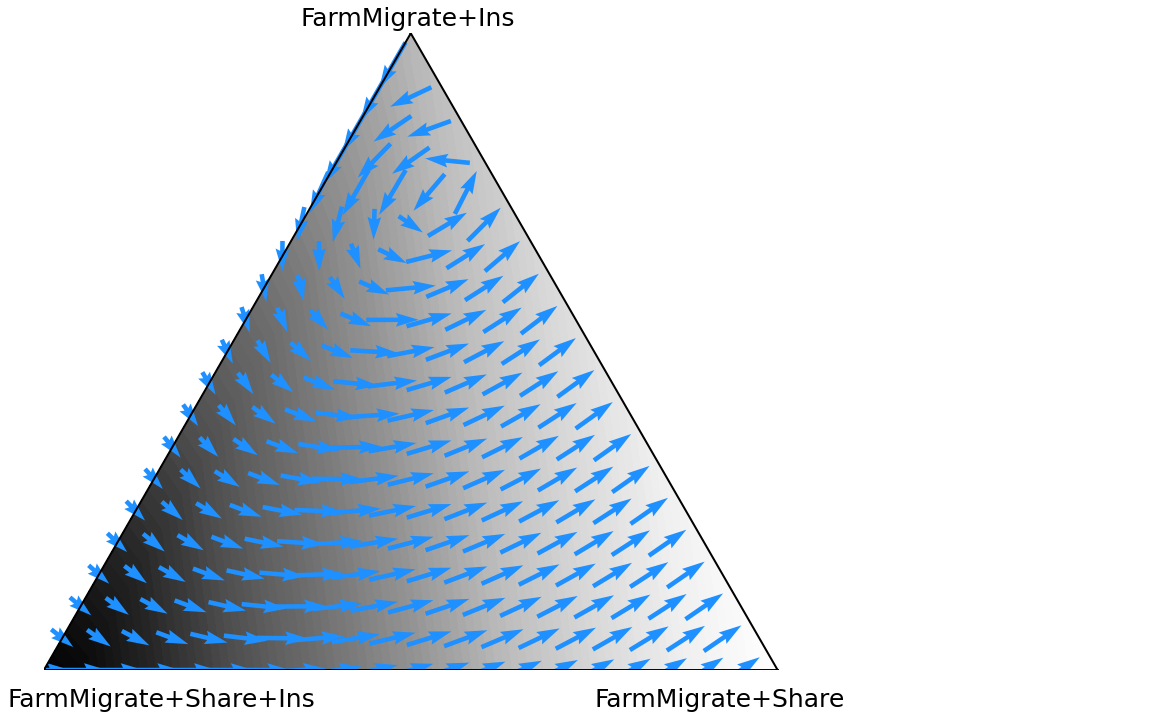

In [76]:
#Quiver Plot

r0=np.array([0,0])
r1=np.array([1,0])
r2=np.array([1/2.,np.sqrt(3)/2.])
corners =np.array([r0,r1,r2])
triangle = tri.Triangulation(corners[:, 0], corners[:, 1])
refiner = tri.UniformTriRefiner(triangle)
trimesh = refiner.refine_triangulation(subdiv=5)
trimesh_fine = refiner.refine_triangulation(subdiv=5)

fig,ax=plt.subplots()

mask = X+Y < 1.0

XX = X + 0.5*Y
YY = np.sqrt(3)/2*Y
x_grad2 = x_grad + 0.5*y_grad
y_grad2 = y_grad * np.sqrt(3)/2

plt.text(-0.05, -0.05, str(strategy_z), size=25)
plt.text(0.75, -0.05, str(strategy_x), size=25)
plt.text(0.35, np.sqrt(3)/2+0.01, str(strategy_y), size=25)

c = plt.contourf(XX, YY, social_util,100, cmap='Greys')
ax.quiver(XX[mask], YY[mask], x_grad2[mask], y_grad2[mask], angles='xy', pivot='mid', color='dodgerblue')
ax.triplot(triangle,linewidth=2.0,color="black")

fig.set_size_inches(16, 10)
plt.tight_layout()
plt.axis('off')
plt.show()

# Simulation Plots

## Single Simulation Plot

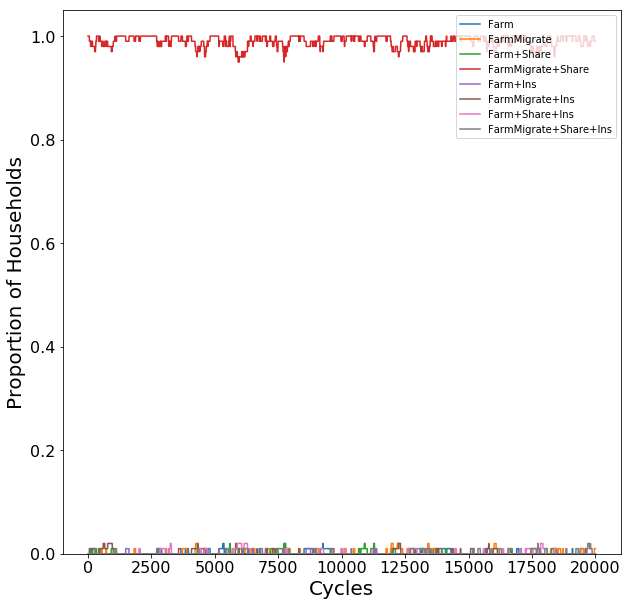

In [22]:
#Plot of strategy distribution over time
#Create arrays for proportion of households in any strategy over time
#time = cycles #Leave in if running financial restrictions model

local_variables = {}
max_value = np.zeros(time)

for item in strategy_names:
    var_name = str(item)
    local_variables[var_name] = np.zeros(time)


#avg_constrained = np.zeros(cycles) #Average number of households constrained at any given time

for t in range(time):
    for var_name, item in zip(local_variables.keys(), strategy_names):      
        local_variables[var_name][t] = sim_frequency_dist[0][t][item]
    max_value[t] = max(sim_frequency_dist[0][t].values())
    
#sim_constrained = np.zeros((simulations,cycles))
#for t in range(time):
    #for a in range(simulations):
        #sim_constrained[a,t] = np.average(constraints[a,t,:])
    
    #avg_constrained[t] = np.average(sim_constrained[:,t])
    
f, ax1 = plt.subplots(figsize=[10,10])
x = np.arange(time)
for key, value in local_variables.items():
    ax1.plot(x, value, label=key)
    
#ax1.plot(x, avg_constrained, linestyle='--', color='dodgerblue', label='Fraction Constrained')    
plt.legend(loc = 'upper right')
ax1.set_ylim([0,1.05])
#ax1.set_xlim([0, 10])
ax1.set_xlabel('Cycles', size=20)
ax1.set_ylabel('Proportion of Households', size=20)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

#plt.savefig('ExampleSelf-Interested.eps', bbox_inches='tight')


## Average of Multiple Simulations over Time

In [ ]:
#Plot of average strategy distribution over time (averaged across simulations)

strategy_names = ['Farm', 'FarmMigrate', 'Farm+Share', 'FarmMigrate+Share', 'Farm+Ins', 'FarmMigrate+Ins', 'Farm+Share+Ins', 'FarmMigrate+Share+Ins']
time = cycles #Leave this in if running financial restrictions model
#simulation_run = np.load('Alpha0.0_Moralis0.0_Drought0.5_Corr0.6_NoMigrate_frequencydist.npy', allow_pickle = True)
simulation_run = sim_frequency_dist
max_value = np.zeros((simulations, time))
avg_max_value = np.zeros(time)

local_variables = {key: [] for key in strategy_names}

avg_sim_time_distribution = {key: [] for key in strategy_names}

for var_name in strategy_names:
    
    local_variables[var_name] = np.zeros((simulations, time))
    for a in range(simulations):
        for t in range(time):
            local_variables[var_name][a,t] = simulation_run[a][t*households][var_name]
    
    avg_time_distribution = np.zeros(time)
    for t in range(time):
        avg_time_distribution[t] = np.average(local_variables[var_name][:,t])
    
    avg_sim_time_distribution[var_name] = avg_time_distribution

    
    
sim_constrained = np.zeros((simulations,cycles))
avg_constrained = np.zeros(time)

for t in range(time):
    for a in range(simulations):
        max_value[a][t] = max(simulation_run[a][t*households].values())
        sim_constrained[a,t] = np.average(constraints[a,t,:])
    avg_max_value[t] = np.average(max_value[:,t])
    avg_constrained[t] = np.average(sim_constrained[:,t])
f, ax = plt.subplots(figsize=[10,10])
x = np.linspace(0, time, time)

labels = []

for key in strategy_names:
    if beta == 0:
        if 'Share' in key:
            equivalent = key.replace('+Share', '')
            labels.append('_')
            avg_sim_time_distribution[equivalent] += avg_sim_time_distribution[key]
            avg_sim_time_distribution[key] = np.zeros(time)
        else:
            labels.append(key)
            
    else:
        labels = strategy_names

for key, label in zip(strategy_names, labels):
    y = np.asarray(avg_sim_time_distribution[key])
    #if label == 'FarmMigrate+Share' or label == 'FarmMigrate+Ins':
    ax.plot(x, y, label = str(label))
    #else:
        #ax.plot(x,y)
    

            
#ax.plot(x, avg_max_value+0.01, ls= (0, (1,10)), color='black', label='Max Value')
ax.plot(x, avg_constrained, ls='--', color='dodgerblue', label='Fraction Constrained')
ax.set_ylim([0,1])
#ax.set_xlim([0,50])
ax.set_xlabel('Cycles', fontsize=20)
ax.set_ylabel('Average Strategy Distribution', fontsize=20)

plt.axvline(ins_start, label='Insurance Introduced', ls='--', color='grey')
plt.xticks(size=18)
plt.yticks(size=18)
#plt.legend(fontsize=18)
plt.show()

#plt.savefig('Combined_Drought0.5_Corr0.6_Restrictions_strategies.png', bbox_inches='tight')


## Economic Outcomes

In [96]:
#Check that correlation is working correctly
t1_start = process_time()
mono_strategies = ['Farm', 'Farm+Share', 'Farm+Ins', 'Farm+Share+Ins']
random.seed(9)

#Setting overall parameters
simulations = 1000
households = 100
scenario_incomes = {key : [] for key in mono_strategies}
scenario_drought = []

rho_array = np.linspace(0.0, 0.2, 11)
print(rho_array)
p_drought = 0.6
p_avg = np.zeros(len(rho_array))
for r in range(len(rho_array)):
    print(r)
    p_cov = rho_array[r]
    adj_k, adj_scale = wei_adjust(mu_farm, farm_k, p_drought, objective_drought, max_farm)
    mu_farm_drought, mu_farm_nd, uninsured_var, insured_var = farm_drought_0(adj_k, adj_scale, p_drought, max_farm)
    non_drought, drought = weib_split(adj_k, adj_scale, p_drought, max_farm)
    rem_mu, rem_sigma = lognorm_factors(mu_migrate, math.sqrt(var_migrate))
    
    p_index = np.zeros(simulations) #Index of drought draws
    drought_status = []
    init_draw = np.zeros((simulations, households)) #Household incomes before adjusting for correlation
    
    for a in range(simulations):
        #Random draw for whether a drought happens in a given simulation
        p_index[a] = np.random.random()
        
        if p_index[a] < p_drought:
            drought_status.append('Drought')
        else:
            drought_status.append('No Drought')
            
        for j in range(households):
            init_draw[a,j] = weib_draw(drought, non_drought, p_index[a], p_drought) #Before adjusting for correlation
        
    #Generating a matrix of dimensions ((households, simulations)) of correlated incomes
    corr_draw = corr_income2(init_draw, p_cov, p_index, p_drought)
    test_incomes = corr_draw #Saving unadulterated income draws for correlation test below
    scenario_drought.append(drought_status)

    ym = np.asmatrix(test_incomes)
    yt = ym.transpose()
    check_matrix = np.corrcoef(yt)
    running_corr = []

    for i in range(households):
        for j in range(households):
            if i < j:
                running_corr.append(check_matrix[i,j])

    p_avg[r] = np.average(running_corr)
print(p_avg)

[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2 ]
0
1
2
3
4
5
6
7
8
9
10
[0.36516715 0.59106833 0.68688308 0.72302967 0.76254334 0.7794248
 0.80068736 0.8177243  0.83066612 0.84181304 0.84291389]


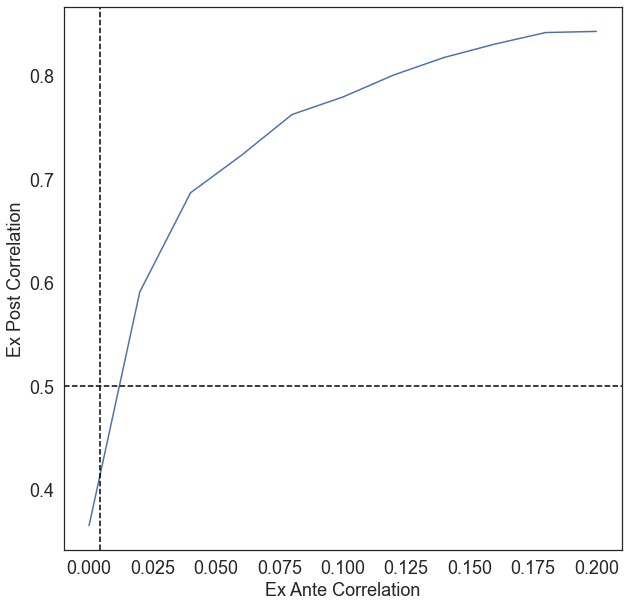

In [97]:
#Plotting Ex Post Correlation vs. Ex Ante Correlation

f, ax1 = plt.subplots(figsize=[10,10])

ax1.plot(rho_array, p_avg)
#ax1.plot(corr_array, corr_array, ls='--', color='black')
ax1.set_xlabel('Ex Ante Correlation', size=18)
ax1.set_ylabel('Ex Post Correlation', size=18)
plt.axhline(0.5, ls='--', color='black')
plt.axvline(0.0045, ls='--', color='black')
plt.xticks(size=18)
plt.yticks(size=18)

plt.show()

#plt.savefig('ExPostExAnte_Risk0.35.png', bbox_inches='tight')

In [76]:
#Generating income distribution of community based on monomorphic strategies

t1_start = process_time()
strategy_names = ['Farm', 'FarmMigrate', 'Farm+Share', 'FarmMigrate+Share', 'Farm+Ins', 'FarmMigrate+Ins', 'Farm+Share+Ins', 'FarmMigrate+Share+Ins']


#Setting overall parameters
simulations = 1000
households = 100
#mono_strategies = ['FarmMigrate', 'FarmMigrate+Share', 'FarmMigrate+Ins', 'FarmMigrate+Share+Ins']
mono_strategies = ['Farm', 'Farm+Share', 'Farm+Ins', 'Farm+Share+Ins']

#risk_levels = {'Low': [0.2, 0.1], 'Medium': [0.35, 0.017], 'High': [0.5, 0.6]}
risk_levels = {'Low': [0.2, 0.00]} #rho = 0.0045 is the ex ante correlation that yields ex post correlation of 0.35 if p = 0.35; #0.01 for p = 0.6

scenario_incomes = {key : [] for key in mono_strategies}
scenario_drought = []

for r in risk_levels:
    print(r)
    random.seed(9)
    p_drought = risk_levels[r][0]
    p_cov = risk_levels[r][1]

    adj_k, adj_scale = wei_adjust(mu_farm, farm_k, p_drought, objective_drought, max_farm)
    mu_farm_drought, mu_farm_nd, uninsured_var, insured_var = farm_drought_0(adj_k, adj_scale, p_drought, max_farm)
    non_drought, drought = weib_split(adj_k, adj_scale, p_drought, max_farm)
    rem_mu, rem_sigma = lognorm_factors(mu_migrate, math.sqrt(var_migrate))
    
    p_index = np.zeros(simulations) #Index of drought draws
    drought_status = []
    init_draw = np.zeros((simulations, households)) #Household incomes before adjusting for correlation
    
    for a in range(simulations):
        #Random draw for whether a drought happens in a given simulation
        p_index[a] = np.random.random()
        
        if p_index[a] < p_drought:
            drought_status.append('Drought')
        else:
            drought_status.append('No Drought')
            
        for j in range(households):
            init_draw[a,j] = weib_draw(drought, non_drought, p_index[a], p_drought) #Before adjusting for correlation
        
    #Generating a matrix of dimensions ((households, simulations)) of correlated incomes
    corr_draw = corr_income2(init_draw, p_cov, p_index, p_drought)
    test_incomes = corr_draw #Saving unadulterated income draws for correlation test below
    scenario_drought.append(drought_status)
    for m in mono_strategies:
        print(m)
        random.seed(24)
        share_contribution = np.zeros((simulations, households))
        farm_incomes = np.zeros((simulations, households)) #Farm income before accounting for costs or migration incomes
        household_incomes = np.zeros((simulations, households)) #Income net of costs  
        farmincomematrix = np.zeros((simulations, households))
        postins_income = np.zeros((simulations, households)) #Income after insurance payout
        farmincomematrix = corr_draw
        
        for a in range(simulations):
            for i in range(households):
                rem_draw = 0
                migrate_adjust = 1
                premium = 0
                
                if 'Migrate' in m:
                    rem_draw = np.random.lognormal(rem_mu, rem_sigma, size=1)
                    migrate_adjust = eta

                if 'Ins' in m:
                    premium = p_drought * migrate_adjust * (mu_farm_nd - mu_farm_drought)
                    
                    if p_index[a] < p_drought:
                        postins_income[a,i] = farmincomematrix[a,i] + (mu_farm_nd - mu_farm_drought) #Migrate adjust applied later
                    else:
                        postins_income[a,i] = farmincomematrix[a,i]
                else:
                    postins_income[a,i] = farmincomematrix[a,i]
                    
                #Distinguishing gross farm income (for income sharing purposes) from total net income
                farm_incomes[a,i] = postins_income[a,i] * migrate_adjust
                household_incomes[a,i] = farm_incomes[a,i] + rem_draw - cost_farm - premium
                
                if 'Share' in m:
                    share_contribution[a,i] = beta * farm_incomes[a,i]
                    household_incomes[a,i] -= share_contribution[a,i]
            
            #Adjusting incomes for shared pool
            pooled_incomes = share_contribution[a,:][share_contribution[a,:] != 0]
            if len(pooled_incomes) == 0:
                pool_contribution = 0
            else:
                pool_contribution = np.average(pooled_incomes)
                if a == 0:
                    print(pool_contribution)
            #Factoring in contributions from shared pool
            for j in range(households):
                if 'Share' in m:
                    household_incomes[a,j] += pool_contribution
                    
                    
        scenario_incomes[m].append(household_incomes)
    

np.save('EconomicOutcomes_NoMigrate.npy', scenario_incomes)
np.save('DroughtStatus.npy', drought_status)
t1_stop = process_time()
print('Elapsed Time:', (t1_stop - t1_start) / 60)

Low
Farm
Farm+Share
5.880714348715307
Farm+Ins
Farm+Share+Ins
67.31866052552415
Elapsed Time: 0.5582631833333332


In [77]:
#Aggregating Mean Income, GINI, and Poverty Rate for risk scenarios and strategies

#scenario_incomes = np.load('EconomicOutcomes.npy', allow_pickle=True)
#drought_status = np.load('DroughtStatus.npy', allow_pickle=True)
#mono_strategies = ['FarmMigrate', 'FarmMigrate+Share', 'FarmMigrate+Ins', 'FarmMigrate+Share+Ins']
#risk_levels = {'Low': [0.2, 0.1], 'Medium': [0.35, 0.35], 'High': [0.5, 0.6]}


sim_income = {key : [] for key in mono_strategies}
sim_full_incomes = {key : [] for key in mono_strategies} #Dictionary with full list of incomes (rather than averaging by simulation)
sim_gini = {key : [] for key in mono_strategies}
sim_poverty = {key : [] for key in mono_strategies}
hh_std = {key : [] for key in mono_strategies}
hh_avg = {key : [] for key in mono_strategies}
sim_loss = {key : [] for key in mono_strategies}
sim_loss_prob = {key : [] for key in mono_strategies}
sim_cvar = {key : [] for key in mono_strategies}
poverty_threshold = 1.9 * 365.25 / 2 #Poverty threshold per cycle, assuming $1.90 USD/day rate



for m in mono_strategies:
    print(m)
    for r in range(len(risk_levels)):
        print(r)
        household_incomes = scenario_incomes[m][r]
        mean_income = np.zeros(simulations)
        gini = np.zeros(simulations)
        poverty_rate = np.zeros(simulations)
        std = np.zeros(households) #Volatility of income for each household across simulations
        hh_income = np.zeros(households)
        hh_loss = np.zeros(households)
        num_losses = np.zeros(households)
        prob_losses = np.zeros(households)
        hh_cvar = np.zeros(households)
        
        for a in range(simulations):
            mean_income[a] = np.average(household_incomes[a,:])
            gini[a] = gini_calc(households, household_incomes[a,:])
            poverty_rate[a] = np.count_nonzero(household_incomes[a,:] < poverty_threshold) / households
            
        for i in range(households):
            std[i] = np.std(household_incomes[:,i])
            hh_income[i] = np.average(household_incomes[:,i])
            num_losses[i] = np.count_nonzero(household_incomes[:,i] < 0)
            prob_losses[i] = num_losses[i] / simulations
            hh_loss[i] = np.sum(household_incomes[:,i][household_incomes[:,i] < 0]) / num_losses[i]
            hh_cvar[i] = hh_loss[i] * 1/(1 - prob_losses[i])
            
        sim_income[m].append(mean_income)
        sim_full_incomes[m].append(household_incomes)
        sim_gini[m].append(gini)
        sim_poverty[m].append(poverty_rate)
        hh_std[m].append(std)
        hh_avg[m].append(hh_income)
        
        sim_loss_prob[m].append(prob_losses)
        sim_loss[m].append(hh_loss)
        sim_cvar[m].append(hh_cvar)

        print('Avg Income:', np.average(sim_income[m]))
        print('Avg GINI:', np.average(sim_gini[m]))
        print('Avg Poverty Rate:', np.average(sim_poverty[m]))

Farm
0
Avg Income: 49.214527468000384
Avg GINI: 0.27889013885184455
Avg Poverty Rate: 0.87749
Farm+Share
0
Avg Income: 49.21452746800039
Avg GINI: 0.26660794994216724
Avg Poverty Rate: 0.9017600000000001
Farm+Ins
0
Avg Income: 54.743942623913185
Avg GINI: 0.3218155400636265
Avg Poverty Rate: 0.9031
Farm+Share+Ins
0
Avg Income: 54.743942623913185
Avg GINI: 0.3131971503119006
Avg Poverty Rate: 0.9252900000000001


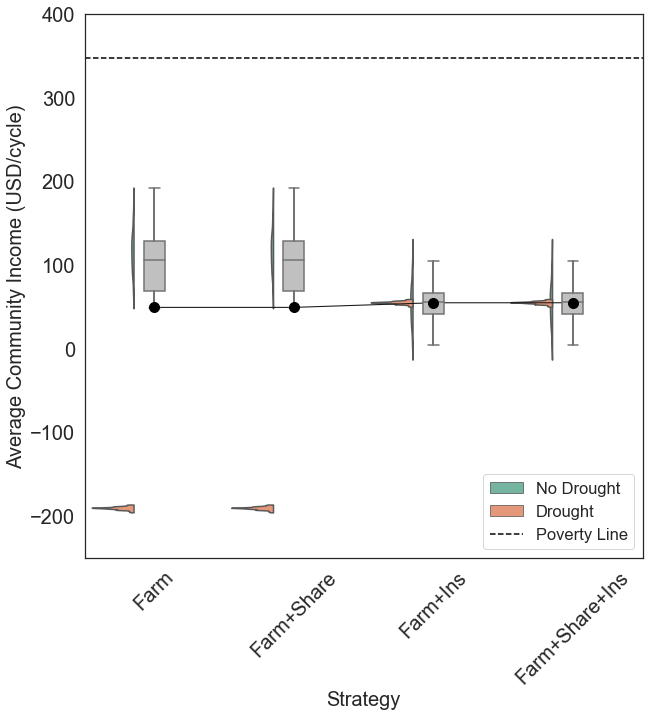

In [84]:
#Blending Raincloud plots for drought vs. non-drought and overall box plot

data_list = []

strategy_list = []
drought_list = []
r = 0 #Index selecting risk scenario

metric_dict = {'Average Community Income (USD/cycle)': sim_income, 'GINI': sim_gini, 'Poverty Rate': sim_poverty, 'Household Incomes (USD/cycle)': sim_full_incomes}

name = 'Average Community Income (USD/cycle)'

for m in mono_strategies: 
    
    #Adjusting dataset for standard deviation (measured by hh) or other metrics (measured by simulation)
    if name == 'Household Incomes (USD/cycle)':
        sim_list = []
        sim_list.append(metric_dict[name][m][r])
        data_list.append([house for simulation in sim_list[0] for house in simulation])
        print(data_list)
        for a in range(simulations):  
            for h in range(households):
                drought_list.append(scenario_drought[r][a])
                strategy_list.append(str(m))
    else:
        data_list.append(metric_dict[name][m][r][0:simulations])
    
        for a in range(simulations):
            strategy_list.append(str(m))
            drought_list.append(scenario_drought[r][a])

sim_data = [run for simulation in data_list for run in simulation]

strategy_df = pd.DataFrame({'Metric': sim_data, 'Strategy': strategy_list, 'Drought': drought_list})

sns.set(style="white", font_scale=1.5)
dx = "Strategy"; dy = 'Metric'; ort="v"; sigma=0.2; pal="Set2"

#add histograms to each plot
f, ax = plt.subplots(figsize=(10, 10))

ax=sns.boxplot( x = dx, y = dy, data = strategy_df, color = "silver", width = .15, zorder = 10,\
            showcaps = True, showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"black", 
                       "markeredgecolor":"black",
                      "markersize":"10"}, boxprops = {'facecolor':'silver', "zorder":10},\
            showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},\
               saturation = 0.4, orient = ort, dodge=True)

ax = sns.pointplot(x=dx, y=dy, data=strategy_df, linestyles='-', scale=0.4, color='k', errwidth=0, capsize=0)


#ax=ptitprince.half_violinplot( x = dx, y = dy, data = strategy_df, palette = pal,
#bw = sigma, cut = 0, scale = "area", width = .6, inner = None,  
 #hue='Drought', hue_order=['No Drought', 'Drought'], dodge=False, saturation=0.7, orient = ort, pointplot=True, move=0.2)

ax=ptitprince.half_violinplot( x = dx, y = dy, data = strategy_df, palette = pal,
bw = sigma, cut = 0, scale = "area", width = .6, inner = None,  
 hue='Drought', hue_order=['No Drought', 'Drought'], dodge=False, saturation=0.7, alpha=1.0, orient = ort)



#ax = ptitprince.RainCloud(x=dx, y=dy, data=strategy_df, bw=sigma, palette = pal, width_viol=0.6, figsize= (8,6), hue='Drought', alpha=0.7, dodge=True, orient=ort, pointplot=True)
#ax = ptitprince.RainCloud(x=dx, y=dy, data=strategy_df, bw=sigma, palette = pal, width_viol=0.6, figsize= (8,6), orient=ort)

#g.map(ptitprince.RainCloud, x=strategy_df['Strategy'], y=strategy_df['Average Income'])

#Note - xaxis limits will need to be adjusted based on the range of the outcome variable visualized
ax.set_xlabel('Strategy', size=20)
ax.set_ylabel(name, size=20)

plt.xticks(fontsize=20, rotation=45)
plt.yticks(size=20)

if name == 'Average Community Income (USD/cycle)':
    plt.axhline(poverty_threshold, color='black', ls='--', label='Poverty Line')
    ax.set_ylim([-250,400])
elif name == 'GINI':
    ax.set_ylim([-0.05, 0.6])
elif name == 'Poverty Rate':
    ax.set_ylim([0.6, 1.05])

plt.legend(loc='lower right')
#plt.show()

plt.savefig('Income_LowRisk_NoMigrate.png', bbox_inches='tight')



{'FarmMigrate': -60.883448674199606, 'FarmMigrate+Share': -61.02074283917013, 'FarmMigrate+Ins': -58.80839654251063, 'FarmMigrate+Share+Ins': -43.61551837861316}


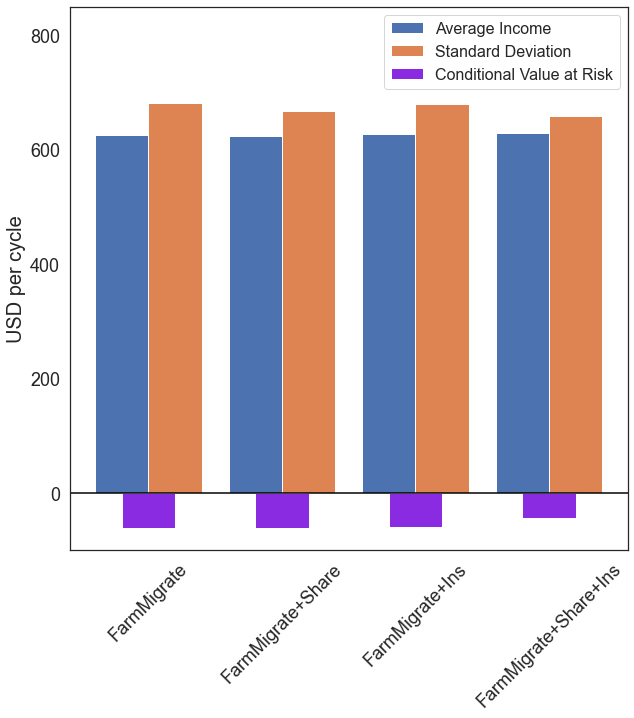

In [106]:
#Bar Graph for Avg Income, Volatility, and Expected Losses
mono_strategies = ['FarmMigrate', 'FarmMigrate+Share', 'FarmMigrate+Ins', 'FarmMigrate+Share+Ins']

avg_income = {key:0 for key in mono_strategies}
std_income = {key:0 for key in mono_strategies}
ci_income = {key:0 for key in mono_strategies}

avg_std = {key:0 for key in mono_strategies}
std_std = {key:0 for key in mono_strategies}
ci_std = {key:0 for key in mono_strategies}

cvar = {key:0 for key in mono_strategies}
losses = {key:0 for key in mono_strategies}
std_loss = {key:0 for key in mono_strategies}
ci_loss = {key:0 for key in mono_strategies}


z_score = 1.959964 #Z score for two-tailed 95% interval

for m in mono_strategies:
    avg_income[m] = np.average(hh_avg[m])
    std_income[m] = np.std(hh_avg[m])
    avg_std[m] = np.average(hh_std[m])
    std_std[m] = np.std(hh_std[m])
    ci_income[m] = z_score * std_income[m] / math.sqrt(households)
    ci_std[m] = z_score * std_std[m] / math.sqrt(households)
    
    losses[m] = np.average(sim_loss[m])
    cvar[m] = np.average(sim_cvar[m])
print(cvar)
income_error = []
for k in ci_income:
    income_error.append(float(ci_income[k]))
    
f, ax = plt.subplots(figsize=(10, 10))
xpos = np.arange(0, len(mono_strategies), 1)
ax.bar(xpos-0.2, avg_income.values(),width=0.4, label='Average Income')
ax.bar(xpos+0.2, avg_std.values(), width=0.4, label='Standard Deviation')
ax.bar(xpos, cvar.values(), width=0.4, label='Conditional Value at Risk', color='blueviolet')
#ax.errorbar(xpos-0.2, avg_income.values(), yerr=income_error, fmt="o", color="grey")


ax.set_ylabel('USD per cycle', size=20)
ax.set_ylim([-100,850])

plt.xticks([r for r in sorted(xpos)], mono_strategies, rotation = 45, fontsize=18)
plt.yticks(fontsize=18)
plt.axhline(0, ls='-', color='black')
plt.legend(fontsize=16)
#plt.show()

plt.savefig('StrategyPayoffDecomposition_Losses_LowRisk.png', bbox_inches='tight')


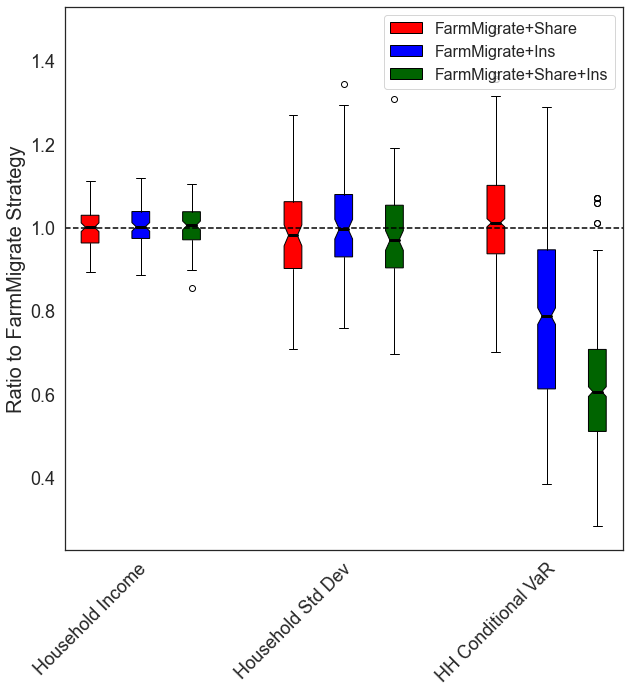

In [108]:
#Normalized plot of version above

norm_income = {key:[] for key in mono_strategies}
norm_std = {key:[] for key in mono_strategies}
norm_loss = {key:[] for key in mono_strategies}
data = {key:[] for key in mono_strategies}

normindices = [norm_income, norm_std, norm_cvar]
metrics = [hh_avg, hh_std, sim_cvar]

for norm, item in zip(normindices, metrics):
    for m in mono_strategies:
        baseline = item['FarmMigrate']
        for i in range(households):
            norm[m].append(item[m][0][i] / baseline[0][i])
        data[m].append(norm[m])
        
f, ax1 = plt.subplots(figsize=[10,10])

bp1 = ax1.boxplot(data['FarmMigrate+Share'], positions=[0, 4, 8], notch=True, widths=0.35, patch_artist=True, boxprops=dict(facecolor="red"))
bp2 = ax1.boxplot(data['FarmMigrate+Ins'], positions=[1, 5, 9], notch=True, widths=0.35, patch_artist=True, boxprops=dict(facecolor="blue"))
bp3 = ax1.boxplot(data['FarmMigrate+Share+Ins'], positions=[2, 6, 10], notch=True, widths=0.35, patch_artist=True, boxprops=dict(facecolor="darkgreen"))
ax1.legend([bp1["boxes"][0], bp2["boxes"][0], bp3['boxes'][0]], ["FarmMigrate+Share", "FarmMigrate+Ins", "FarmMigrate+Share+Ins"], loc='upper right', fontsize=16)



data = [bp1, bp2, bp3]
for s in data:
    for median in s['medians']:
        median.set(color ='black',
              linewidth = 3)
        

ax1.set_xticklabels(['Household Income', 'Household Std Dev','HH Conditional VaR', '', '','', '','', ''], fontsize=18, rotation=45)
#ax1.set_ylim([0,1.6])
ax1.set_ylabel('Ratio to FarmMigrate Strategy', fontsize=20)
plt.axhline(1, ls='--', color='black')
plt.yticks(fontsize=18)
#plt.show()
plt.savefig('RatioDecomposition_LowRisk.png', bbox_inches='tight')



## Single-Parameter Sensitivity

In [45]:
#Create arrays for proportion of households in any strategy over time
parameter_array = ['0.0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0']


sens_frequency_dist = {}
avg_proportion = {key: [] for key in strategy_names}
std_proportion = {key: [] for key in strategy_names}

avg_final_proportion = {key: [] for key in strategy_names}
std_final_proportion = {key: [] for key in strategy_names}


for value in parameter_array:
    key = str(value)
    sens_frequency_dist[key] = np.load('Self-Interested_BetaSens' + '_frequencydist.npy', allow_pickle=True)
    local_variables = {}
    avg_sim_proportion = {}
    final_sim_proportion = {}
    avg_time_proportion = {}

    for item in strategy_names:
        var_name = str(item)
        local_variables[var_name] = np.zeros((simulations,time))
        avg_sim_proportion[var_name] = np.zeros(simulations)
        final_sim_proportion[var_name] = np.zeros(simulations)
        avg_time_proportion[var_name] = np.zeros(time)

    for a in range(simulations):
        for t in range(time):
            for var_name, item in zip(local_variables.keys(), strategy_names):      
                local_variables[var_name][a,t] = sens_frequency_dist[value][-1][a][t][item]

    for var_name in local_variables.keys():
        
        for sim in range(simulations):
            avg_sim_proportion[var_name][sim] = np.average(local_variables[var_name][sim,:])
            final_sim_proportion[var_name][sim] = local_variables[var_name][sim,-1]
            
        avg_proportion[var_name].append(np.average(avg_sim_proportion[var_name]))
        avg_final_proportion[var_name].append(np.average(final_sim_proportion[var_name]))
        
        std_proportion[var_name].append(np.std(avg_sim_proportion[var_name]))
        std_final_proportion[var_name].append(np.std(final_sim_proportion[var_name]))


IndexError: index 5000 is out of bounds for axis 0 with size 5000

In [ ]:
#Line Plot of Avg Strategy Proportions as a function of parameter

f, ax = plt.subplots(figsize=[10,10])
x = np.linspace(0.0, 1.0, 6)
max_values = np.zeros((sensitivity_steps, simulations))
avg_max_values = np.zeros(sensitivity_steps)

for i in range(sensitivity_steps):
    for a in range(simulations):
        max_values[i,a] = max(sens_frequency_dist[i][a][-1])
    avg_max_values[i] = np.average(max_values[:,a])


for key in strategy_names:
    y = np.asarray(avg_proportion[key])
    err = np.asarray(std_proportion[key])
    ax.plot(x, y, label = str(key))
    #ax.fill_between(x, y - err, y + err)

    ax.set_ylim([0,1])
ax.set_xlabel('Moralis $k$ factor')
ax.set_ylabel('Avg Strategy Share')
plt.legend()
plt.show()

#plt.savefig('Altruistic_AltruismSens.png', bbox_inches='tight')

## Bar Graph of Final Strategy Proportions

In [15]:
#Bar Graph of average strategy distributions over simulations

#Create arrays for proportion of households in any strategy over time

local_variables = {}
avg_time_proportion = {}
avg_proportion={}


for item in strategy_names:
    var_name = str(item)
    local_variables[var_name] = np.zeros((simulations,time))
    avg_time_proportion[var_name] = np.zeros(time)

for a in range(simulations):
    for t in range(time):
        for var_name, item in zip(local_variables.keys(), strategy_names):      
            local_variables[var_name][a,t] = sim_frequency_dist[a][t][item]

for var_name in local_variables.keys():
    for t in range(time):
        avg_time_proportion[var_name][t] = np.average(local_variables[var_name][:,t])
    
    avg_proportion[var_name] = np.average(avg_time_proportion[var_name])



f, ax = plt.subplots(figsize=[10,10])
x = np.arange(time)

categories = np.arange(1)
ax.bar(categories, avg_proportion['FarmMigrate'], label='FarmMigrate', color='orange')
ax.bar(categories, avg_proportion['FarmMigrate+Share'], bottom=avg_proportion['FarmMigrate'], label='FarmMigrate+Share', color='red')
ax.bar(categories, avg_proportion['FarmMigrate+Ins'], bottom=(avg_proportion['FarmMigrate+Share'] + avg_proportion['FarmMigrate']), label='FarmMigrate+Ins', color='sienna')
ax.bar(categories, avg_proportion['FarmMigrate+Share+Ins'], bottom=(avg_proportion['FarmMigrate+Ins'] + avg_proportion['FarmMigrate+Share'] + avg_proportion['FarmMigrate']), label='FarmMigrate+Share+Ins', color='black')

#ax1.plot(x, local_variables['FarmMigrate+Ins_prop'], linestyle='--')
#print(local_variables['FarmMigrate+Ins_prop'])
plt.legend()

#ax1.set_xlabel('Time Steps', size=20)
ax.set_ylabel('Proportion of Time Spent in Each Strategy', size=20)

plt.yticks(fontsize=16)
plt.show()

#np.save(avg_proportion, 'P0.3_proportion_10sim.npy')

#print(type(avg_proportion))
#data = json.dumps(avg_proportion)
#f = open("P0.01_proportion.json","w")
#f.write(data)
#f.close()

#plt.savefig('Altruism05_10sim.eps', bbox_inches='tight')

NameError: name 'strategy_names' is not defined

#Bar plot of multiple worldviews
strategy_names = ['Farm', 'FarmMigrate', 'Farm+Share', 'FarmMigrate+Share', 'Farm+Ins', 'FarmMigrate+Ins', 'Farm+Share+Ins', 'FarmMigrate+Share+Ins']
worldviews_intl = {'Self-Interested':{key:0 for key in strategy_names}, 'Altruistic':{key:0 for key in strategy_names}, 'Solidarity':{key:0 for key in strategy_names}}
worldviews_local = {'Self-Interested':{key:0 for key in strategy_names}, 'Altruistic':{key:0 for key in strategy_names}, 'Solidarity':{key:0 for key in strategy_names}}

self_interested = np.load('Self-Interested_frequencydist.npy', allow_pickle=True)
altruistic = np.load('Altruistic_frequencydist.npy', allow_pickle=True)
solidarity = np.load('Moralis_frequencydist.npy', allow_pickle=True)

local_self_interested = np.load('Self-Interested_localmigrate_frequencydist.npy', allow_pickle=True)
local_altruistic = np.load('Altruistic_localmigrate_frequencydist.npy', allow_pickle=True)
local_solidarity = np.load('Moralis_localmigrate_frequencydist.npy', allow_pickle=True)

barWidth = 0.3

data_intl = [self_interested, altruistic, solidarity]
data_local = [local_self_interested, local_altruistic, local_solidarity]
fig, ax = plt.subplots(figsize=[20,10])
xpos_intl = np.arange(len(data_intl))
xpos_local = [x + barWidth for x in xpos_intl]

#Loop through this next part

for i, view in enumerate(worldviews_intl):
    final_distributions_intl = {key : [] for key in strategy_names}
    final_distributions_local = {key : [] for key in strategy_names}

    for item in strategy_names:
        for a in range(simulations):
            final_distributions_intl[item].append(data_intl[i][a][-1][item])
            final_distributions_local[item].append(data_local[i][a][-1][item])

        worldviews_intl[view][item] = np.average(final_distributions_intl[item])         
        worldviews_local[view][item] = np.average(final_distributions_local[item])         

y_intl = np.zeros((len(strategy_names), len(worldviews_intl)))
y_local = np.zeros((len(strategy_names), len(worldviews_local)))

for j, strategy in enumerate(strategy_names):
    for i, view in enumerate(worldviews_intl):
        y_intl[j][i] = worldviews_intl[view][strategy]
        y_local[j][i] = worldviews_local[view][strategy]
        
running_bottom_intl = np.zeros(len(worldviews_intl))
running_bottom_local = np.zeros(len(worldviews_intl))

for i, strategy in enumerate(strategy_names):
    ax.bar(sorted(xpos_intl), y_intl[i], bottom = running_bottom_intl, align='center', label=str(strategy))
    running_bottom_intl += y_intl[i]
    ax.bar(sorted(xpos_local), y_local[i], bottom = running_bottom_local, align='center', label=str(strategy))
    running_bottom_local += y_local[i]    

#ax.set_xticklabels(['Self-Interested', 'Altruistic', 'Solidarity'])
ax.set_ylim([0,1])
ax.set_ylabel('Proportion of Households (Average)', size=18)
ax.set_xlabel('Worldviews', size=18)
plt.xticks([r + barWidth for r in range(len(xpos_intl))], ['Self-Interested', 'Altruistic', 'Solidarity'], fontsize=18)
plt.yticks(fontsize=18)
#plt.legend(fontsize=16)
plt.show()

#plt.savefig('Worldviewcomparison_local.png', bbox_inches='tight')

# Transition Matrix Calculations

#strategy_names = ['Farm', 'FarmMigrate', 'Farm+Share', 'FarmMigrate+Share', 'Farm+Ins', 'FarmMigrate+Ins', 'Farm+Share+Ins', 'FarmMigrate+Share+Ins']
strategy_names = ['Farm', 'Farm+Ins', 'Farm+Share', 'Farm+Share+Ins', 'FarmMigrate', 'FarmMigrate+Ins', 'FarmMigrate+Share', 'FarmMigrate+Share+Ins']
mu_farm_drought, mu_farm_nd, uninsured_var, insured_var = farm_drought(mu_farm, farm_k, p_drought, objective_drought)
matrix = transition_matrix(strategy_names, households, utility_function, risk_factor, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, eta, mu_migrate, uninsured_var, insured_var, var_migrate, beta, cost_farm, cost_migrate, p_drought, altruism_factor, max_altruism, k, mutation_rate)
print(matrix)

#transpose_matrix = np.transpose(matrix)

from scipy.linalg import eig
from array import array

a = []
for key in matrix:
    row = []
    for item in matrix[key]:
        row.append(matrix[key][item])
    a.append(row)
    
probability_matrix = np.array(a)
print('Matrix:', probability_matrix)

transpose_matrix = [[probability_matrix[j][i] for j in range(len(trans_matrix))] for i in range(len(trans_matrix[0]))]
print('Transpose:', transpose_matrix)

A=np.append(np.transpose(probability_matrix)-np.identity(8),[[1,1,1,1,1,1,1,1]],axis=0) 
b=np.transpose(np.array([0,0,0,0,0,0,0,0,1]))
eigen = np.linalg.solve(np.transpose(A).dot(A), np.transpose(A).dot(b))

total = np.sum(eigen)
stationary_dist = []
for value in eigen:
    stationary_dist.append(np.abs(value)/ total)
    
stationary_dist

#w,v = scipy.linalg.eig(probability_matrix, left=True, right=False)

#print('E-value:', w)
#print('E-vector', v)
#idx = np.argmin(np.abs(w - 1))
#vec = np.real(v[idx])

#print('Stationary Distribution:', vec/np.sum(vec))

#for value, vector in zip(w,v):
    #if value == 1:
    #if np.min(vector) > -0.01:
        #stationary_dist = []
        #total = np.sum(np.abs(vector))
        #for value in vector:
            #stationary_dist.append(np.abs(value) / total)
        #print('Possible distribution:', stationary_dist)

# Calculate Utilities as a Function of Strategy Share

In [42]:
#Calculate income distribution properties

p_drought = 0.2
p_cov = 0.1
#cost_migrate = 0
losav= 1.33
risk_factor = 0.5
altruism_factor = 0.0
k = 0.0
subsidy = 0
adj_k, adj_scale = wei_adjust(mu_farm, farm_k, p_drought, objective_drought, max_farm)
mu_farm_drought, mu_farm_nd, uninsured_var, insured_var = farm_drought_0(adj_k, adj_scale, p_drought, max_farm)

#Calculate utility of strategy x as a function of share of population playing strategy

strategy_names = ['Farm', 'FarmMigrate', 'Farm+Share', 'FarmMigrate+Share', 'Farm+Ins', 'FarmMigrate+Ins', 'Farm+Share+Ins', 'FarmMigrate+Share+Ins']
x = np.arange(0,households,1)

#target_strategy = ['Farm+Share', 'FarmMigrate+Ins', 'FarmMigrate+Share', 'FarmMigrate+Share+Ins']
target_strategy = ['Farm', 'Farm+Share', 'Farm+Ins', 'Farm+Share+Ins', 'FarmMigrate', 'FarmMigrate+Share', 'FarmMigrate+Share+Ins', 'FarmMigrate+Ins', ]


color_dict = {'Farm': 'blue', 'Farm+Share': 'green', 'Farm+Ins': 'purple', 'Farm+Share+Ins': 'pink', 'FarmMigrate': 'orange', 'FarmMigrate+Share': 'red', 'FarmMigrate+Ins': 'brown', 'FarmMigrate+Share+Ins': 'gray'}

y = {key: np.zeros(len(x)) for key in target_strategy}


alternate_strategy = 'FarmMigrate+Share+Ins'


for strategy in target_strategy:
    for i in range(households):
        distribution = []
        frequency = {key: 0 for key in strategy_names}
       
        if strategy == alternate_strategy:
            frequency[strategy] = households / households
        else:
            frequency[strategy] = i / households
            frequency[alternate_strategy] = (households - i) / households
        
        distribution.append(frequency)
        
        utility = utility_select(utility_function, strategy_names, risk_factor, distribution, alternate_strategy, strategy, households, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, eta, mu_migrate, subsidy, matching, uninsured_var, insured_var, var_migrate, p_cov, rho_mig, beta, cost_farm, cost_migrate, p_drought, time_horizon, discount_rate, altruism_factor, max_altruism, k)

        y[strategy][i] = utility[1]
        

#sorted_strat = np.sort(y['FarmMigrate+Share+Ins'])
#crossover = np.argwhere(y['FarmMigrate+Share+Ins'] > y['FarmMigrate+Share'][0])[0] / households
#print(crossover)
        

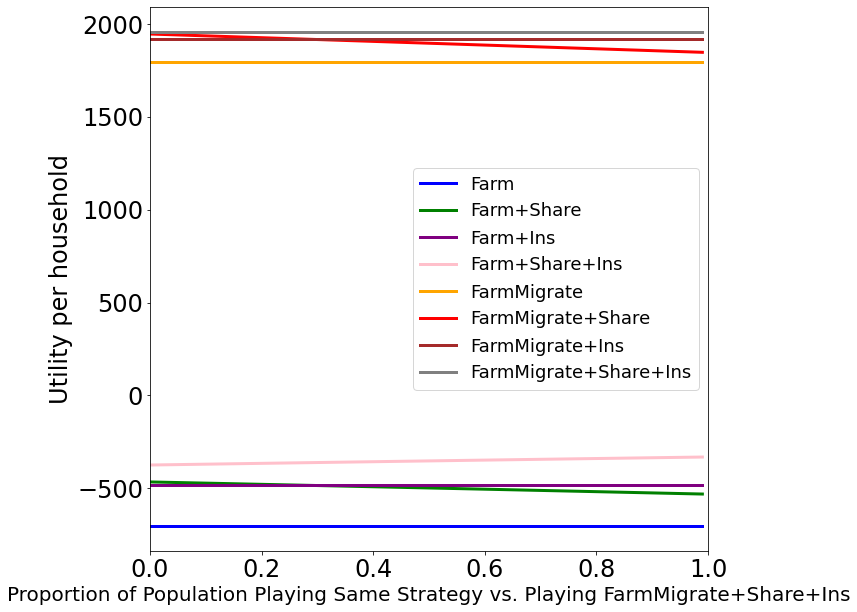

In [43]:
#Plot results

f, ax1 = plt.subplots(figsize=[10,10])

for key in color_dict:
    ax1.plot(x / households, y[key], label=str(key), color=color_dict[key], lw=3)

ax1.set_xlabel('Proportion of Population Playing Same Strategy vs. Playing ' + str(alternate_strategy), size=20)
#ax1.set_xlabel('Proportion of Population Playing Target Strategy', size=24)

ax1.set_ylabel('Utility per household', size = 24)
ax1.set_xlim([0,1.0])

#ax1.set_ylim([2250,2750])
plt.legend(fontsize=18)
#plt.axvline(crossover, ls = '--', label='Coordination Point')
#plt.legend(fontsize=18, loc='center right')
plt.xticks(np.arange(0, 1.05, 0.2), fontsize=24)
plt.yticks(fontsize=24)


plt.show()

prefix = str(utility_function) + '_Drought' + str(p_drought) + '_Corr' + str(p_cov) + '_Base' + str(alternate_strategy)
#plt.savefig(str(prefix) + '_Utilities.png', bbox_inches='tight')

# Monomorphic State Utilities as a Function of Worldviews

In [ ]:
#Worldview Parameters
utility_function = 'Moralis'
migration_type = 'International'
risk_factor = 0.5
beta = 0.25
discount_rate = 0.05
p_cov = 0.6

if migration_type == 'International':
    mu_migrate = 594.8
    var_migrate = 998.2 ** 2
    cost_migrate = 500
    
elif migration_type == 'Local':
    mu_migrate = 200 
    var_migrate = 190 ** 2 
    cost_migrate = 62.5

else: 
    raise ValueError ('Migration type improperly specified')

In [ ]:
#Calculating utilities of each monomorphic strategy type

strategy_names = ['Farm', 'FarmMigrate', 'Farm+Share', 'FarmMigrate+Share', 'Farm+Ins', 'FarmMigrate+Ins', 'Farm+Share+Ins', 'FarmMigrate+Share+Ins']
npv_incomes = {key: 0 for key in strategy_names}
npv_std = {key: 0 for key in strategy_names}
utilities = {key: 0 for key in strategy_names}
prior_distribution = []

for item in strategy_names:
    distribution = {key: 0 for key in strategy_names}
    distribution[item] = 1.0
    prior_distribution.append(distribution)
    prior_distribution.append(distribution)
    #income = income_calc(strategy_names, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, eta, mu_migrate, beta, losav, distribution, cost_farm, cost_migrate, p_drought, subsidy, matching, time_horizon, discount_rate)[0][item]
    income = payoffs_calc(strategy_names, p_drought, mu_farm_nd, mu_farm_drought, eta, mu_migrate, beta, distribution, matching, cost_farm, subsidy, time_horizon, losav, cost_migrate)[item]

    npv_incomes[item] = npv_calc(income, time_horizon, discount_rate)
    
    std= variance_calc(mu_farm, farm_k, p_drought, eta, uninsured_var, insured_var, var_migrate, beta, rho_mig, distribution, households, p_cov, strategy_names, time_horizon, discount_rate)[item]
    npv_std[item] = npv_calc(std, time_horizon, discount_rate)

    utilities[item] = utility_select(utility_function, strategy_names, risk_factor, prior_distribution, item, item, households, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, eta, mu_migrate, subsidy, matching, uninsured_var, insured_var, var_migrate, p_cov, rho_mig, beta, cost_farm, cost_migrate, p_drought, time_horizon, discount_rate, altruism_factor, max_altruism, k)[0]

#strategy_labels = ['Farm', 'FarmMigrate', '', 'Farm+Share', '', 'FarmMigrate+Share', '', 'Farm+Ins', '', 'FarmMigrate+Ins', '', 'Farm+Share+Ins', '', 'FarmMigrate+Share+Ins']

print(utilities)

plt.bar(utilities.keys(), utilities.values())
plt.xticks(rotation=90)
ax = plt.gca()
#ax.set_xticklabels(labels=npv_incomes.keys(),rotation=90)
ax.set_ylabel('NPV Utility ($)')
plt.show()

#plt.savefig('MonomorphicUtilities_FutureMindedCollaborator_fixedstrategies.png', bbox_inches='tight')


# Plot Fermi Probabilities as a Function of Relative Utility Difference

In [14]:
#Calculate transition probability of switching from strategy x to y as a function of relative utility differences

def fermi_prob(rel_utility_gap, sel_strength):
        
    #Probability will be lower value (closer to 0) when selection strength and utility difference is high
    try:
        transition_probability = (1 + math.exp(sel_strength * (-rel_utility_gap))) ** (-1)
    except OverflowError:
        transition_probability = 0
    
    return transition_probability

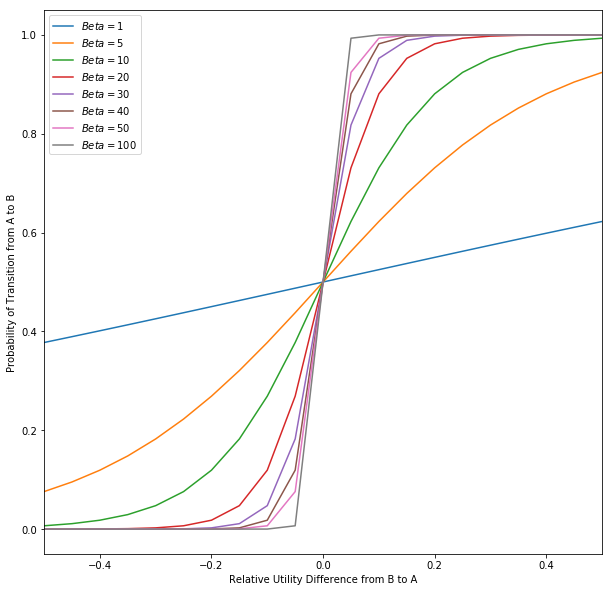

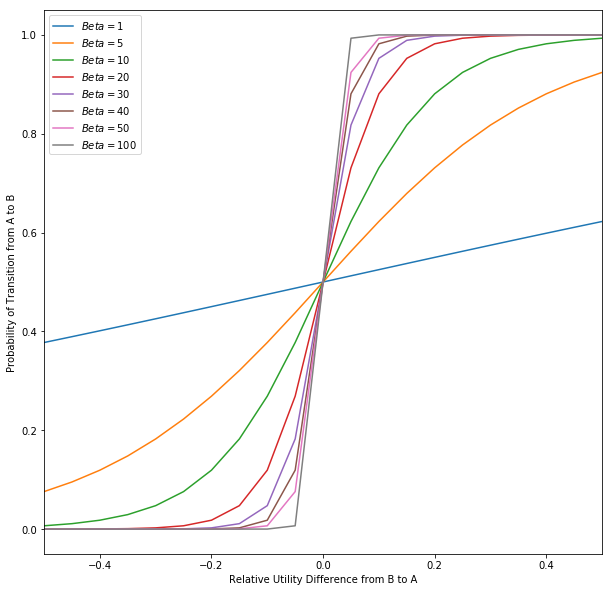

In [27]:
#Generate Plot of probability vs. utility gap
sel_strength = [1, 5, 10, 20, 30, 40, 50, 100]
utility_gaps = np.linspace(-1, 1, 41)
trans_prob = np.zeros((len(sel_strength), len(utility_gaps)))

for j, value in enumerate(sel_strength):
    for i in range(len(utility_gaps)):
        trans_prob[j, i] = fermi_prob(utility_gaps[i], value)


f, ax1 = plt.subplots(figsize=[10,10])

for k, item in enumerate(sel_strength):
    ax1.plot(utility_gaps, trans_prob[k], label = '$Beta = $' + str(item))
    
ax1.set_xlabel('Relative Utility Difference from B to A')
ax1.set_ylabel('Probability of Transition from A to B')
ax1.set_xlim([-0.5, 0.5])

plt.legend()
plt.show()

#plt.savefig('Logisticfunction_Betasens.png', bbox_inches='tight')

In [ ]:
#Plot of average strategy distribution over time

#Create arrays for proportion of households in any strategy over time

local_variables = {}
avg_proportion = {}


for item in strategy_names:
    var_name = str(item)
    local_variables[var_name] = np.zeros((simulations,time))
    avg_time_proportion[var_name] = np.zeros(time)

for a in range(simulations):
    for t in range(time):
        for var_name, item in zip(local_variables.keys(), strategy_names):      
            local_variables[var_name][a,t] = sim_frequency_dist[a][t][item]

for var_name in local_variables.keys():
    for t in range(time):
        avg_time_proportion[var_name][t] = np.average(local_variables[var_name][:,t])
    
    avg_proportion[var_name] = np.average(avg_time_proportion[var_name])
    
f, ax1 = plt.subplots(figsize=[10,10])
x = np.arange(time)
for key, value in avg_proportion.items():
    ax1.plot(x, value, label=key)

#ax1.plot(x, local_variables['FarmMigrate+Ins_prop'], linestyle='--')
#print(local_variables['FarmMigrate+Ins_prop'])
plt.legend()
ax1.set_ylim([0,1])
ax1.set_xlim([0, time])

ax1.set_xlabel('Time Steps', size=20)
ax1.set_ylabel('Proportion of Households', size=20)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

#plt.savefig('Altruism05.eps', bbox_inches='tight')


In [ ]:
# Create Bar plot with separate bars for each drought probability tested

probabilities = [0.01, 0.05, 0.1, 0.3]
local_variables = {}
means = {'FarmMigrate':[], 'FarmMigrate+Share':[], 'FarmMigrate+Ins':[], 'FarmMigrate+Share+Ins':[]}



for item in probabilities:
    
    f = open('P' + str(item) + '_proportion.json',)
    var_name = ('p_' + str(item))
    local_variables[var_name] = json.load(f)
    f.close()


categories = means.keys()

for strategy in categories:
    for key,value in local_variables.items():
        means[strategy].append(local_variables[key][strategy])

probability_order = list(local_variables.keys())

f, ax = plt.subplots(figsize=[10,10])

bottom_1 = means['FarmMigrate']
bottom_2 = [means['FarmMigrate'][i] + means['FarmMigrate+Share'][i] for i in range(len(means['FarmMigrate']))]
bottom_3 = [means['FarmMigrate'][i] + means['FarmMigrate+Share'][i] + means['FarmMigrate+Ins'][i] for i in range(len(means['FarmMigrate']))]

#[test_list1[i] + test_list2[i] for i in range(len(test_list1))]
ax.bar(probability_order, means['FarmMigrate'], label = 'FarmMigrate', color='dodgerblue')
ax.bar(probability_order, means['FarmMigrate+Share'], bottom = bottom_1, label = 'FarmMigrate+Share', color='green')
ax.bar(probability_order, means['FarmMigrate+Ins'], bottom = bottom_2, label = 'FarmMigrate+Ins', color='salmon')
ax.bar(probability_order, means['FarmMigrate+Share+Ins'], bottom = bottom_3, label = 'FarmMigrate+Share+Ins', color='darkorchid')

ax.set_xlabel('Drought Probability', size=18)
ax.set_ylabel('Proportion of Time', size=18)


plt.legend(fontsize=16)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)


#plt.show()

plt.savefig('DroughtSensitivity.eps', bbox_inches='tight')

## Insurance Premiums as Function of Drought Risk

In [16]:
#Plot insurance premiums as a function of drought risks
mu_farm = 260.9 #For cereal crops only 176.5 #For all crops 260.93 #Previously mu_farm = 163.4
farm_k = 0.798 

drought_min = 0.1
drought_max = 1.0
p_drought = np.arange(drought_min, drought_max, 0.1)
premiums = np.zeros(len(p_drought))
avg_income = np.zeros(len(p_drought))
drought_threshold = np.zeros(len(p_drought))
variance = np.zeros(len(p_drought))


for i, p in enumerate(p_drought):
    print(i)
    adj_k, adj_scale = wei_adjust(mu_farm, farm_k, p, objective_drought, max_farm)
    mu_farm_drought, mu_farm_nd, uninsured_var, insured_var = farm_drought_0(adj_k, adj_scale, p, max_farm)
    premiums[i] = p * eta * (mu_farm_nd - mu_farm_drought)
    avg_income[i] = mu_farm_nd
    drought_threshold[i] = mu_farm_drought
    variance[i] = uninsured_var

    
print(premiums)

f, ax1 = plt.subplots(figsize=[10,10])

ax1.plot(p_drought, premiums, label='Premiums')
ax1.plot(p_drought, avg_income, label = 'Avg Non-Drought Income')
ax1.plot(p_drought, drought_threshold, label = 'Drought Income', ls='--')

ax1.set_xlabel('Drought Probability', size=18)
ax1.set_ylabel('Insurance Premium (USD/cycle)', size=18)

#ax2 = ax1.twinx()
#ax2.plot(p_drought, variance, label='Variance', color='green')
plt.legend()
plt.show()

#plt.savefig('Premiums_Reshaped.png', bbox_inches='tight')

0
1
2
3
4
5
6
7
8
[ 27.88610193  43.85228506  55.45903598  63.83604623  78.96984506
  82.32039453  91.32151672 102.31024393 103.97274178]


#Plotting Weibull Distribution as a function of p_drought and shift
drought_values = [0.2, 0.5, 0.8]

variance = np.zeros(len(drought_values))
points = 1000000
n_bins = 1000
scale = (mu_farm / math.gamma(1 + 1 / farm_k))

income_distribution = scale * np.random.weibull(farm_k, size=100000)

sorted_income = list(np.sort(income_distribution))
drought_index = int(objective_drought * len(sorted_income)) - 1 
drought_threshold = sorted_income[drought_index]
f, axs = plt.subplots(2, 1, figsize=[10,10])

for i, p_drought in enumerate(drought_values):    
    #Shift drought threshold by tau to get p_drought density below drought threshold
    shift_index = int(p_drought * len(sorted_income)) - 1 #This establishes the two portions of distribution over which we will average, then shift
    shift_threshold = sorted_income[shift_index]
    tau = drought_threshold - shift_threshold
    shifted_income = list(np.sort(income_distribution + tau))
    adj_income = np.clip(shifted_income, 0, max_farm)
    mu_farm_test = np.average(adj_income)
    
    variance[i] = trunc_var(adj_income, mu_farm)
    
    
    axs[0].hist(adj_income, bins=n_bins, label='p =' + str(p_drought))
    
#axs[0].set_xlim([-750,750])
axs[0].set_ylim([0, 10000])
axs[0].set_xlabel('Income (USD/cycle)', fontsize=18)
axs[0].set_ylabel('Density', fontsize=18)
axs[0].axvline(drought_threshold, color='black')

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
axs[0].legend(fontsize=18)

axs[1].plot(drought_values, variance)
plt.show()

#plt.savefig('ShiftedWeibullDistributions_trunc.png', bbox_inches='tight')



In [61]:
#Plotting Weibull Distribution as a function of p_drought and shift
drought_values = [0.2, 0.5, 0.8]
variance = np.zeros(len(drought_values))
adj_mu_farm = np.zeros(len(drought_values))
std_dev = np.zeros(len(drought_values))


n_bins=1000
f, axs = plt.subplots(2, 1, figsize=[10,10])
for i, p_drought in enumerate(drought_values): 
    mu_farm = 260.93 #Previously mu_farm = 163.4
    farm_k = 0.798 
    print('Drought Risk:', p_drought)
    adj_k, adj_scale = wei_adjust(mu_farm, farm_k, p_drought, objective_drought, max_farm)
    income_distribution = np.array(adj_scale * np.random.weibull(adj_k, size=100000), dtype=float)
    #adj_income = np.array(np.clip(income_distribution, None, max_farm), dtype=float)
    adj_mu_farm[i] = np.average(income_distribution)
    variance[i] = trunc_var(income_distribution, adj_mu_farm[i])
    std_dev[i] = math.sqrt(variance[i])

    
    axs[0].hist(income_distribution, bins=n_bins, label='p =' + str(p_drought), density=True)

print(variance)
axs[0].set_ylim([0,0.005])
axs[0].set_xlabel('Income (USD/cycle)')
axs[0].set_ylabel('Density')
axs[0].legend()


axs[1].plot(drought_values, std_dev, label = 'Std. Dev' )
axs[1].plot(drought_values, adj_mu_farm, label = 'Mean')
axs[1].set_xlabel('Drought Risk', fontsize=18)
axs[1].set_ylabel('USD/cycle', fontsize=18)

plt.legend(fontsize=16)
#plt.show()
plt.savefig('ReshapedWeibullDistr.png', bbox_inches='tight')

Drought Risk: 0.2
Drought Risk: 0.5
Drought Risk: 0.8
[58363.55171426 26688.16330043 11103.61995943]


Drought Risk: 0.35
Drought Threshold: 62.59108043019127


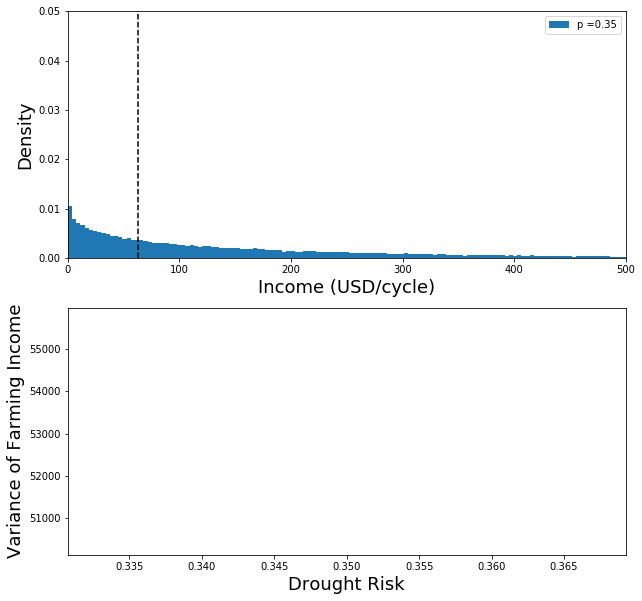

In [16]:
#Plotting Weibull Distribution as a histogram
drought_values = [0.35]

mu_farm = 260.93 #Previously mu_farm = 163.4
farm_k = 0.798 #For STD = 321; previously k = 0.808 #Shape factor for farming income distribution (Weibull)
max_farm = 2500 #99th percentile of farm income/cycle (in USD) to truncate Weibull - based on CVFS total revenues
variance = np.zeros(len(drought_values))
n_bins=1000
f, axs = plt.subplots(2, 1, figsize=[10,10])

for i, p_drought in enumerate(drought_values): 
    print('Drought Risk:', p_drought)
    objective_drought = 0.3
    adj_k, adj_scale = wei_adjust(mu_farm, farm_k, p_drought, objective_drought, max_farm)
    income_distribution = np.array(adj_scale * np.random.weibull(adj_k, size=100000), dtype=float)
    drought_index = int(p_drought * len(income_distribution))
    drought_threshold = np.sort(income_distribution)[drought_index]
    print('Drought Threshold:', drought_threshold)
    axs[0].hist(income_distribution, bins=n_bins, label='p =' + str(p_drought), density=True)
    #adj_income = np.array(np.clip(income_distribution, None, max_farm), dtype=float)
    mu_farm_adj = np.average(income_distribution)
    variance[i] = trunc_var(income_distribution, mu_farm_adj)

    
    

axs[0].set_ylim([0,0.05])
axs[0].set_xlim([0,500])
axs[0].axvline(drought_threshold, color='black', ls='--')
axs[0].set_xlabel('Income (USD/cycle)', fontsize=18)
axs[0].set_ylabel('Density', fontsize=18)
axs[0].legend()

axs[1].plot(drought_values, variance)
axs[1].set_ylabel('Variance of Farming Income', fontsize=18)
axs[1].set_xlabel('Drought Risk', fontsize=18)

plt.show()

#plt.savefig('ReshapedWeibullDistr.png', bbox_inches='tight')

